# Import

In [ ]:
!pip install pytorch-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.3 MB/s eta 0:00:00


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00


In [ ]:
import os
import random
import sklearn.metrics as skm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Embedding, LSTM, Bidirectional, BatchNormalization
from tensorflow.keras.models import Sequential
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
import xgboost as xgb
from keras.models import load_model
from keras import regularizers
from keras.utils import FeatureSpace
from tensorflow import keras
import pickle

# For 1D-Resnet Library
import seaborn as sns
from numpy import interp
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.metrics import classification_report, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from keras.layers import Input, UpSampling1D, concatenate, BatchNormalization, Activation, add
from keras.layers import Conv2D, MaxPooling2D, Reshape, Flatten, Dense
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# For SAE-DNN
import time
from tensorflow.keras import backend as K

# For tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import optuna

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Proyek Magang/TF-1D-2D-ResNetV1-2-SEResNet-ResNeXt-SEResNeXt-main/Codes

/content/drive/MyDrive/Proyek Magang/TF-1D-2D-ResNetV1-2-SEResNet-ResNeXt-SEResNeXt-main/Codes


In [ ]:
from SE_ResNeXt_1DCNN import SEResNeXt

In [ ]:
tf.compat.v1.reset_default_graph()

SEED = 42  # use this constant seed everywhere

# Input Data

Tersedia 5 data yang berbeda :
- data_1to1 (1) = data yang mengandung interaksi positif dan negatif dengan rasio jumlah 1:1
- data_ohc (2) = data 1:3 yang kolom XY nya sudah dilakukan one-hot encoding
- data (3) = data yang mengandung interaksi positif dan negatif dengan rasio jumlah 1:3
- data_1to5 (4) = data yang mengandung interaksi positif dan negatif dengan rasio jumlah 1:5
- data_1to5_ohc (5) = data 1:5 yang kolom XY nya sudah dilakukan one-hot encoding

In [ ]:
def pilih_data(pilihan):
  if pilihan == 1:
    data = pd.read_csv('/content/drive/MyDrive/Proyek Magang/PepPi_full_interaction_data_1to1.csv')
    data = data.iloc[:, :605].join(data.iloc[:, 705:1305].join(data.iloc[:, 605:705].join(data.iloc[:, 1305:])))
  elif pilihan == 2:
    temp_data1 = pd.read_csv('/content/drive/MyDrive/Proyek Magang/PepPi_full_interaction_data_OHC.csv')
    temp_data2 = pd.read_csv('/content/drive/MyDrive/Proyek Magang/PepPi_full_interaction_data.csv')
    data = pd.concat([temp_data2.iloc[:, 0:5], temp_data1], axis=1)
  elif pilihan == 3:
    data = data = pd.read_csv('/content/drive/MyDrive/Proyek Magang/PepPi_full_interaction_data.csv')
    data = data.iloc[:, :605].join(data.iloc[:, 705:1305].join(data.iloc[:, 605:705].join(data.iloc[:, 1305:])))
  elif pilihan == 4:
    data = data = pd.read_csv('/content/drive/MyDrive/Proyek Magang/PepPi_full_interaction_data_1to5.csv')
    data = data.iloc[:, :605].join(data.iloc[:, 705:1305].join(data.iloc[:, 605:705].join(data.iloc[:, 1305:])))
  elif pilihan == 5:
    data = data = pd.read_csv('/content/drive/MyDrive/Proyek Magang/PepPi_full_interaction_data_1to5_OHC.csv')
  return data

In [ ]:
pilihan = 4
data = pilih_data(pilihan)

# Eksplorasi Data

Utk penjelasan fitur peptida dan proteinnya :
- 0-399 : PSSM (Position-Specific Scoring Matrix)
- 400-599 : ID (Intrinsic Disorder)
- X : AAS (Amino Acid Sequence)
- Y : PP (Physicochemical Properties)

Letak fitur pada data (utk data non-OHC) :
- 0-399 pep : **[5:405]**
- 400-599 pep : **[405:605]**
- 0-399 prot : **[605:1005]**
- 400-599 prot : **[1005:1205]**
- X_pep : **[1205:1255]**
- Y_pep : **[1255:1305]**
- X_prot : **[1305:2746]**
- Y_prot : **[2746:4187]**

In [ ]:
data.iloc[:,5:405].describe()

,0_pep,1_pep,2_pep,3_pep,4_pep,5_pep,6_pep,7_pep,8_pep,9_pep,...,390_pep,391_pep,392_pep,393_pep,394_pep,395_pep,396_pep,397_pep,398_pep,399_pep
count,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,...,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000
mean,-0.912056,-0.494998,-2.679001,-2.120808,-3.144619,-0.802793,-1.433253,-0.968292,-2.064837,-1.196817,...,-0.973579,-0.701540,1.664796,-0.095150,-0.533266,-0.060341,0.346199,0.068605,0.276950,-0.667562
std,0.554445,0.526511,1.479608,2.464610,2.725578,0.484109,0.729606,0.650308,1.158196,0.555740,...,0.454515,0.486215,1.176691,0.591129,0.798633,0.786989,0.526679,0.223294,1.310534,0.647338
min,-9.000000,-1.222314,-9.388889,-13.604167,-19.687500,-1.505556,-4.916667,-2.794643,-4.344136,-2.367769,...,-2.250000,-3.750000,0.285714,-2.250000,-2.250000,-1.238482,-0.570526,-0.394671,-3.750000,-2.250000
25%,-1.055556,-1.039365,-3.288580,-2.426667,-3.076667,-1.323333,-1.758929,-1.157025,-2.608586,-1.426768,...,-1.149691,-1.022222,0.490000,-0.716529,-1.114268,-0.796046,-0.201613,-0.039926,-0.714286,-1.190335
50%,-0.852893,-0.394558,-2.871074,-1.097724,-2.551136,-0.888889,-1.478336,-0.753651,-2.115701,-1.000000,...,-0.812925,-0.500785,1.455525,0.158095,-0.646094,0.142857,0.571429,0.078071,-0.412698,-0.817460
75%,-0.615556,0.049863,-1.586527,-0.859695,-1.934760,-0.313570,-0.942598,-0.537755,-0.840000,-0.738889,...,-0.623264,-0.296478,2.900884,0.425049,0.252948,0.697531,0.849206,0.234217,1.462564,-0.059167
max,-0.334541,0.247767,-0.506997,-0.219884,-1.025262,-0.050236,-0.347908,-0.055556,-0.513605,-0.510465,...,-0.181902,-0.015235,3.583333,0.559975,1.119057,1.010744,2.250000,0.750000,3.324211,0.452971


In [ ]:
data.iloc[:, 1205:1255].describe()

,X1_pep,X2_pep,X3_pep,X4_pep,X5_pep,X6_pep,X7_pep,X8_pep,X9_pep,X10_pep,...,X41_pep,X42_pep,X43_pep,X44_pep,X45_pep,X46_pep,X47_pep,X48_pep,X49_pep,X50_pep
count,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,...,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000
mean,11.854351,12.594764,12.178097,11.735251,12.422198,11.966077,12.170723,11.481563,10.245575,10.424779,...,0.818215,0.738569,0.491150,0.436209,0.455015,0.424410,0.332596,0.289823,0.171091,0.048304
std,7.391898,6.171341,6.406982,6.465809,6.738614,6.637221,7.295319,6.568120,6.519116,7.014835,...,3.695900,3.419822,2.627198,2.427021,2.451184,2.525452,2.187115,2.323853,1.721971,0.663278
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,7.000000,6.000000,6.000000,6.000000,6.000000,6.000000,7.000000,5.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,14.000000,12.000000,10.000000,12.000000,12.000000,12.000000,12.000000,10.000000,12.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18.000000,18.000000,17.000000,17.000000,17.000000,17.000000,18.000000,17.000000,15.000000,17.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,...,23.000000,23.000000,22.000000,22.000000,21.000000,21.000000,20.000000,22.000000,20.000000,10.000000


In [ ]:
data.iloc[:, 1255:1305].describe()

,Y1_pep,Y2_pep,Y3_pep,Y4_pep,Y5_pep,Y6_pep,Y7_pep,Y8_pep,Y9_pep,Y10_pep,...,Y41_pep,Y42_pep,Y43_pep,Y44_pep,Y45_pep,Y46_pep,Y47_pep,Y48_pep,Y49_pep,Y50_pep
count,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,...,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000
mean,3.446165,3.646386,3.351401,3.613201,3.161504,3.467552,3.255900,3.070059,2.962389,2.533923,...,0.176622,0.209440,0.133481,0.155605,0.119838,0.120206,0.097714,0.055310,0.037979,0.025811
std,2.076563,1.979225,1.873746,1.979911,1.871692,1.962498,2.191194,2.194582,2.147474,1.995280,...,0.813116,0.930851,0.736286,0.815367,0.744846,0.726485,0.666173,0.515958,0.380785,0.368530
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,6.000000,5.000000,5.000000,5.000000,5.000000,6.000000,5.000000,5.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000


In [ ]:
if pilihan != 2 or pilihan != 5:
  to_find_X_pep = data.iloc[:, 1205:1255]
  unique_val_X_pep = np.concatenate([to_find_X_pep[column].unique() for column in to_find_X_pep.columns])
  unique_val_X_pep = np.unique(unique_val_X_pep)

  to_find_Y_pep = data.iloc[:, 1255:1305]
  unique_val_Y_pep = np.concatenate([to_find_Y_pep[column].unique() for column in to_find_Y_pep.columns])
  unique_val_Y_pep = np.unique(unique_val_Y_pep)

  to_find_X_prot = data.iloc[:, 1305:2746]
  unique_val_X_prot = np.concatenate([to_find_X_prot[column].unique() for column in to_find_X_prot.columns])
  unique_val_X_prot = np.unique(unique_val_X_prot)

  to_find_Y_prot = data.iloc[:, 2746:4187]
  unique_val_Y_prot = np.concatenate([to_find_Y_prot[column].unique() for column in to_find_Y_prot.columns])
  unique_val_Y_prot = np.unique(unique_val_Y_prot)

  print("Unique val X_pep : ", unique_val_X_pep)
  print("Unique val Y_pep : ", unique_val_Y_pep)
  print("Unique val X_prot : ", unique_val_X_prot)
  print("Unique val Y_prot : ", unique_val_Y_prot)

Unique val X_pep :  [ 0  1  2  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24]
Unique val Y_pep :  [0 1 2 3 4 5 6 7]
Unique val X_prot :  [ 0  1  2  4  5  6  7  8  9 10 11 12 14 15 16 17 18 20 21 22 23]
Unique val Y_prot :  [0 1 2 3 4 5 6]


In [ ]:
'''
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(data.iloc[:, 1205:])
encoded_data = encoder.transform(data.iloc[:, 1205:])
feature_names = encoder.get_feature_names_out(data.iloc[:, 1205:].columns)
encoded_df = pd.DataFrame(encoded_data, columns=feature_names).astype(int)
'''

"\nencoder = OneHotEncoder(sparse=False, handle_unknown='ignore')\nencoder.fit(data.iloc[:, 1205:])\nencoded_data = encoder.transform(data.iloc[:, 1205:])\nfeature_names = encoder.get_feature_names_out(data.iloc[:, 1205:].columns)\nencoded_df = pd.DataFrame(encoded_data, columns=feature_names).astype(int)\n"

In [ ]:
data.iloc[:, 5:1205]

,0_pep,1_pep,2_pep,3_pep,4_pep,5_pep,6_pep,7_pep,8_pep,9_pep,...,590_prot,591_prot,592_prot,593_prot,594_prot,595_prot,596_prot,597_prot,598_prot,599_prot
0,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,-2.244010,-0.826042,...,0.8200,0.2164,0.9362,0.2720,0.7772,0.2720,0.9081,0.3625,0.7388,0.3625
1,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,-2.244010,-0.826042,...,0.0363,0.1964,0.0618,0.2023,0.0336,0.2023,0.0405,0.2063,0.0259,0.2063
2,-1.252232,-0.392857,-3.330357,-4.187500,-3.859375,-0.859375,-1.758929,-2.794643,-1.698661,-0.937500,...,0.3053,0.3517,0.3215,0.3710,0.2913,0.3710,0.2645,0.3902,0.2432,0.3902
3,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,-2.584813,-1.642505,...,0.4282,0.3501,0.6043,0.3600,0.5084,0.3600,0.5342,0.3743,0.4245,0.3743
4,-2.666667,-0.020833,-7.666667,-13.604167,-19.687500,-1.333333,-4.916667,-0.187500,-1.250000,-1.000000,...,0.7034,0.7891,0.5211,0.7658,0.6789,0.7658,0.4149,0.7354,0.6035,0.7354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,-1.185016,0.160076,-0.868956,-0.859695,-3.059174,-0.066459,-0.475824,-0.487270,-0.720604,-0.634305,...,0.0660,0.3427,0.1115,0.3556,0.0660,0.3556,0.1349,0.3543,0.0858,0.3543
2708,-1.185016,0.160076,-0.868956,-0.859695,-3.059174,-0.066459,-0.475824,-0.487270,-0.720604,-0.634305,...,0.3668,0.4124,0.4292,0.4094,0.4333,0.4094,0.4441,0.4050,0.4420,0.4050
2709,-1.185016,0.160076,-0.868956,-0.859695,-3.059174,-0.066459,-0.475824,-0.487270,-0.720604,-0.634305,...,0.6124,0.7071,0.5211,0.7421,0.5900,0.7421,0.4619,0.7802,0.5374,0.7802
2710,-1.185016,0.160076,-0.868956,-0.859695,-3.059174,-0.066459,-0.475824,-0.487270,-0.720604,-0.634305,...,0.3992,0.3957,0.3631,0.3924,0.3939,0.3924,0.3494,0.3919,0.3762,0.3919


In [ ]:
# data_ohc = pd.concat([data.iloc[:, 0:1205], encoded_df], axis=1)

In [ ]:
# data_ohc.to_csv('PepPi_full_interaction_data_1to5_OHC.csv', index=False)

In [ ]:
positive_count = sum(data['inter_res'] == 1)
negative_count = sum(data['inter_res'] == 0)

print(f"Number of positive interactions: {positive_count}")
print(f"Number of negative interactions: {negative_count}")

Number of positive interactions: 452
Number of negative interactions: 2260


# Preprocessing Data

Hilangkan 5 kolom diawal untuk X dan ambil kolom 'inter_res' untuk Y

In [ ]:
X = data.drop(['pdb_chain', 'Uniprot_chain', 'inter_res', 'pep_seq', 'prot_seq'], axis=1)
Y = data['inter_res']

In [ ]:
X.iloc[:, :1200]

,0_pep,1_pep,2_pep,3_pep,4_pep,5_pep,6_pep,7_pep,8_pep,9_pep,...,590_prot,591_prot,592_prot,593_prot,594_prot,595_prot,596_prot,597_prot,598_prot,599_prot
0,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,-2.244010,-0.826042,...,0.8200,0.2164,0.9362,0.2720,0.7772,0.2720,0.9081,0.3625,0.7388,0.3625
1,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,-2.244010,-0.826042,...,0.0363,0.1964,0.0618,0.2023,0.0336,0.2023,0.0405,0.2063,0.0259,0.2063
2,-1.252232,-0.392857,-3.330357,-4.187500,-3.859375,-0.859375,-1.758929,-2.794643,-1.698661,-0.937500,...,0.3053,0.3517,0.3215,0.3710,0.2913,0.3710,0.2645,0.3902,0.2432,0.3902
3,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,-2.584813,-1.642505,...,0.4282,0.3501,0.6043,0.3600,0.5084,0.3600,0.5342,0.3743,0.4245,0.3743
4,-2.666667,-0.020833,-7.666667,-13.604167,-19.687500,-1.333333,-4.916667,-0.187500,-1.250000,-1.000000,...,0.7034,0.7891,0.5211,0.7658,0.6789,0.7658,0.4149,0.7354,0.6035,0.7354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,-1.185016,0.160076,-0.868956,-0.859695,-3.059174,-0.066459,-0.475824,-0.487270,-0.720604,-0.634305,...,0.0660,0.3427,0.1115,0.3556,0.0660,0.3556,0.1349,0.3543,0.0858,0.3543
2708,-1.185016,0.160076,-0.868956,-0.859695,-3.059174,-0.066459,-0.475824,-0.487270,-0.720604,-0.634305,...,0.3668,0.4124,0.4292,0.4094,0.4333,0.4094,0.4441,0.4050,0.4420,0.4050
2709,-1.185016,0.160076,-0.868956,-0.859695,-3.059174,-0.066459,-0.475824,-0.487270,-0.720604,-0.634305,...,0.6124,0.7071,0.5211,0.7421,0.5900,0.7421,0.4619,0.7802,0.5374,0.7802
2710,-1.185016,0.160076,-0.868956,-0.859695,-3.059174,-0.066459,-0.475824,-0.487270,-0.720604,-0.634305,...,0.3992,0.3957,0.3631,0.3924,0.3939,0.3924,0.3494,0.3919,0.3762,0.3919


In [ ]:
X

,0_pep,1_pep,2_pep,3_pep,4_pep,5_pep,6_pep,7_pep,8_pep,9_pep,...,Y1432_prot,Y1433_prot,Y1434_prot,Y1435_prot,Y1436_prot,Y1437_prot,Y1438_prot,Y1439_prot,Y1440_prot,Y1441_prot
0,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,-2.244010,-0.826042,...,0,0,0,0,0,0,0,0,0,0
1,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,-2.244010,-0.826042,...,0,0,0,0,0,0,0,0,0,0
2,-1.252232,-0.392857,-3.330357,-4.187500,-3.859375,-0.859375,-1.758929,-2.794643,-1.698661,-0.937500,...,1,4,6,6,6,6,1,1,6,1
3,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,-2.584813,-1.642505,...,0,0,0,0,0,0,0,0,0,0
4,-2.666667,-0.020833,-7.666667,-13.604167,-19.687500,-1.333333,-4.916667,-0.187500,-1.250000,-1.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,-1.185016,0.160076,-0.868956,-0.859695,-3.059174,-0.066459,-0.475824,-0.487270,-0.720604,-0.634305,...,0,0,0,0,0,0,0,0,0,0
2708,-1.185016,0.160076,-0.868956,-0.859695,-3.059174,-0.066459,-0.475824,-0.487270,-0.720604,-0.634305,...,1,1,4,6,4,4,1,4,4,4
2709,-1.185016,0.160076,-0.868956,-0.859695,-3.059174,-0.066459,-0.475824,-0.487270,-0.720604,-0.634305,...,5,4,4,3,2,4,4,1,1,1
2710,-1.185016,0.160076,-0.868956,-0.859695,-3.059174,-0.066459,-0.475824,-0.487270,-0.720604,-0.634305,...,1,1,1,1,6,1,1,1,6,1


In [ ]:
X.iloc[:, 1200:]

,X1_pep,X2_pep,X3_pep,X4_pep,X5_pep,X6_pep,X7_pep,X8_pep,X9_pep,X10_pep,...,Y1432_prot,Y1433_prot,Y1434_prot,Y1435_prot,Y1436_prot,Y1437_prot,Y1438_prot,Y1439_prot,Y1440_prot,Y1441_prot
0,6,8,20,20,8,10,4,11,6,18,...,0,0,0,0,0,0,0,0,0,0
1,6,8,20,20,8,10,4,11,6,18,...,0,0,0,0,0,0,0,0,0,0
2,1,18,20,10,15,20,1,18,10,0,...,1,4,6,6,6,6,1,1,6,1
3,10,4,14,1,12,12,18,23,12,12,...,0,0,0,0,0,0,0,0,0,0
4,24,21,18,22,16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,20,10,5,4,23,4,18,9,14,17,...,0,0,0,0,0,0,0,0,0,0
2708,20,10,5,4,23,4,18,9,14,17,...,1,1,4,6,4,4,1,4,4,4
2709,20,10,5,4,23,4,18,9,14,17,...,5,4,4,3,2,4,4,1,1,1
2710,20,10,5,4,23,4,18,9,14,17,...,1,1,1,1,6,1,1,1,6,1


In [ ]:
Y

0       0
1       0
2       0
3       0
4       0
       ..
2707    1
2708    1
2709    1
2710    1
2711    1
Name: inter_res, Length: 2712, dtype: int64

## Scaling

In [ ]:
X.iloc[:, :600].describe()

,0_pep,1_pep,2_pep,3_pep,4_pep,5_pep,6_pep,7_pep,8_pep,9_pep,...,590_pep,591_pep,592_pep,593_pep,594_pep,595_pep,596_pep,597_pep,598_pep,599_pep
count,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,...,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000
mean,-0.912056,-0.494998,-2.679001,-2.120808,-3.144619,-0.802793,-1.433253,-0.968292,-2.064837,-1.196817,...,0.012033,0.005698,0.003834,0.004848,0.010286,0.004848,0.001250,0.001719,0.005615,0.001719
std,0.554445,0.526511,1.479608,2.464610,2.725578,0.484109,0.729606,0.650308,1.158196,0.555740,...,0.093474,0.052963,0.039658,0.048543,0.088763,0.048543,0.016979,0.023916,0.065753,0.023916
min,-9.000000,-1.222314,-9.388889,-13.604167,-19.687500,-1.505556,-4.916667,-2.794643,-4.344136,-2.367769,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.055556,-1.039365,-3.288580,-2.426667,-3.076667,-1.323333,-1.758929,-1.157025,-2.608586,-1.426768,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.852893,-0.394558,-2.871074,-1.097724,-2.551136,-0.888889,-1.478336,-0.753651,-2.115701,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-0.615556,0.049863,-1.586527,-0.859695,-1.934760,-0.313570,-0.942598,-0.537755,-0.840000,-0.738889,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,-0.334541,0.247767,-0.506997,-0.219884,-1.025262,-0.050236,-0.347908,-0.055556,-0.513605,-0.510465,...,0.965300,0.807400,0.694800,0.801800,0.953400,0.801800,0.250300,0.376300,0.839100,0.376300


In [ ]:
X.iloc[:, 600:1200].describe()

,0_prot,1_prot,2_prot,3_prot,4_prot,5_prot,6_prot,7_prot,8_prot,9_prot,...,590_prot,591_prot,592_prot,593_prot,594_prot,595_prot,596_prot,597_prot,598_prot,599_prot
count,2.712000e+03,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,...,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000
mean,6.913364e+15,5084.634879,4308.938565,3347.792958,3376.228205,4709.042025,3457.987177,3512.112574,3527.154198,3733.295590,...,0.368228,0.450008,0.418885,0.447104,0.363205,0.447104,0.404382,0.444579,0.349944,0.444579
std,2.366853e+16,17053.600510,13391.578537,12430.595038,12153.177769,15557.565666,12450.649173,12555.898817,12673.124732,12815.873688,...,0.251045,0.213761,0.274840,0.210763,0.248267,0.210763,0.272985,0.207491,0.245125,0.207491
min,-1.280000e+16,-282.897178,-773.048304,-872.152116,-549.586706,-709.085952,-83.198388,-187.778842,-621.881673,-263.211512,...,0.002800,0.003100,0.003800,0.004500,0.001200,0.004500,0.003800,0.005800,0.000800,0.005800
25%,-9.422023e-01,0.193447,0.070978,-0.421639,-0.719205,0.181737,-0.405052,-0.130810,-0.359298,-0.239797,...,0.169800,0.350200,0.206400,0.360000,0.153200,0.360000,0.179100,0.362500,0.138000,0.362500
50%,-9.422023e-01,0.212636,0.070978,-0.392071,-0.656881,0.182807,-0.365738,-0.119064,-0.312345,-0.191057,...,0.322500,0.417200,0.356600,0.419900,0.314600,0.419900,0.363100,0.417900,0.296300,0.417900
75%,-5.029626e-01,1090.887230,1.048122,-0.074297,0.003006,364.441287,0.154174,0.197043,0.061497,0.207607,...,0.525300,0.485100,0.637500,0.477600,0.551400,0.477600,0.549300,0.478400,0.517300,0.478400
max,1.860000e+17,130964.070000,86029.131300,90882.950160,86851.850710,105089.802100,91769.238760,92489.521620,90914.853550,89397.231620,...,0.900900,0.994400,0.965700,0.995300,0.916200,0.995300,0.960600,0.995600,0.910300,0.995600


In [ ]:
X.iloc[:, 400:600]

,400_pep,401_pep,402_pep,403_pep,404_pep,405_pep,406_pep,407_pep,408_pep,409_pep,...,590_pep,591_pep,592_pep,593_pep,594_pep,595_pep,596_pep,597_pep,598_pep,599_pep
0,0.7209,0.8055,0.9562,0.8055,0.5992,0.8120,0.9068,0.8120,0.6482,0.8130,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.7209,0.8055,0.9562,0.8055,0.5992,0.8120,0.9068,0.8120,0.6482,0.8130,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.9756,0.9804,1.0000,0.9804,0.9756,0.9781,1.0000,0.9781,0.9756,0.9724,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.2364,0.2485,0.7772,0.2485,0.2783,0.2439,0.7388,0.2439,0.3149,0.2423,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.2224,0.3562,0.9960,0.3562,0.2224,0.3562,0.9960,0.3562,0.2224,0.3562,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,0.5758,0.3979,0.9257,0.3979,0.5901,0.4026,0.9009,0.4026,0.3948,0.4036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2708,0.5758,0.3979,0.9257,0.3979,0.5901,0.4026,0.9009,0.4026,0.3948,0.4036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2709,0.5758,0.3979,0.9257,0.3979,0.5901,0.4026,0.9009,0.4026,0.3948,0.4036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2710,0.5758,0.3979,0.9257,0.3979,0.5901,0.4026,0.9009,0.4026,0.3948,0.4036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Lakukan normalisasi data dengan MinMaxScaler pada 600 fitur peptida dan 600 fitur protein.

In [ ]:
# Lakukan MinMaxScaling pada kolom fitur peptida & protein

inputan = 1

def pilih_normalisasi(inputan):
  if inputan == 1: # 600 fitur protein peptida akan dinormalisasikan secara bersamaan
    X.iloc[:, :1200] = pd.DataFrame(data = MinMaxScaler().fit_transform(X.iloc[:,:1200]), columns = X.iloc[:,:1200].columns)
  elif inputan == 2: # 400 fitur protein dan 400 fitur peptida akan dinormalisasikan secara independen
    X.iloc[:, :400] = pd.DataFrame(data = MinMaxScaler().fit_transform(X.iloc[:,:400]), columns = X.iloc[:,:400].columns)
    X.iloc[:, 600:1000] = pd.DataFrame(data = MinMaxScaler().fit_transform(X.iloc[:,600:1000]), columns = X.iloc[:,600:1000].columns)

pilih_normalisasi(inputan)

In [ ]:
# Apakah scaling fitur PSSM dan ID secara independen sama dengan jika fitur PSSM dan ID discaling secara bersamaan
'''
# test = scaling PSSM dan ID secara bersamaan
test = X.copy()
test.iloc[:, :1200] = pd.DataFrame(data = MinMaxScaler().fit_transform(X.iloc[:,:1200]), columns = X.iloc[:,:1200].columns)

# X = scaling PSSM dan ID secara independen
X.iloc[:, :400] = pd.DataFrame(data = MinMaxScaler().fit_transform(X.iloc[:,:400]), columns = X.iloc[:,:400].columns)
X.iloc[:, 400:600] = pd.DataFrame(data = MinMaxScaler().fit_transform(X.iloc[:,400:600]), columns = X.iloc[:,400:600].columns)
X.iloc[:, 600:1000] = pd.DataFrame(data = MinMaxScaler().fit_transform(X.iloc[:,600:1000]), columns = X.iloc[:,600:1000].columns)
X.iloc[:, 1000:1200] = pd.DataFrame(data = MinMaxScaler().fit_transform(X.iloc[:,1000:1200]), columns = X.iloc[:,1000:1200].columns)

# Membandingkan apakah test == X
test.equals(X)
'''

'\n# test = scaling PSSM dan ID secara bersamaan\ntest = X.copy()\ntest.iloc[:, :1200] = pd.DataFrame(data = MinMaxScaler().fit_transform(X.iloc[:,:1200]), columns = X.iloc[:,:1200].columns)\n\n# X = scaling PSSM dan ID secara independen\nX.iloc[:, :400] = pd.DataFrame(data = MinMaxScaler().fit_transform(X.iloc[:,:400]), columns = X.iloc[:,:400].columns)\nX.iloc[:, 400:600] = pd.DataFrame(data = MinMaxScaler().fit_transform(X.iloc[:,400:600]), columns = X.iloc[:,400:600].columns)\nX.iloc[:, 600:1000] = pd.DataFrame(data = MinMaxScaler().fit_transform(X.iloc[:,600:1000]), columns = X.iloc[:,600:1000].columns)\nX.iloc[:, 1000:1200] = pd.DataFrame(data = MinMaxScaler().fit_transform(X.iloc[:,1000:1200]), columns = X.iloc[:,1000:1200].columns)\n\n# Membandingkan apakah test == X\ntest.equals(X)\n'

In [ ]:
X.iloc[:, :400].describe()

,0_pep,1_pep,2_pep,3_pep,4_pep,5_pep,6_pep,7_pep,8_pep,9_pep,...,390_pep,391_pep,392_pep,393_pep,394_pep,395_pep,396_pep,397_pep,398_pep,399_pep
count,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,...,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000
mean,0.933354,0.494745,0.755457,0.857973,0.886436,0.482892,0.762442,0.666774,0.595035,0.630458,...,0.617196,0.816239,0.418205,0.766858,0.509559,0.523799,0.325019,0.404724,0.569244,0.585444
std,0.063983,0.358151,0.166587,0.184142,0.146048,0.332648,0.159695,0.237418,0.302359,0.299219,...,0.219774,0.130186,0.356831,0.210368,0.237049,0.349893,0.186731,0.195073,0.185255,0.239491
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.916794,0.124448,0.686825,0.835121,0.890077,0.125211,0.691159,0.597870,0.453083,0.506649,...,0.532039,0.730375,0.061949,0.545724,0.337107,0.196706,0.130796,0.309910,0.429124,0.392037
50%,0.940182,0.563069,0.733832,0.934413,0.918237,0.423733,0.752574,0.745136,0.581756,0.736427,...,0.694878,0.869992,0.354744,0.856981,0.476070,0.614140,0.404873,0.412994,0.471756,0.529987
75%,0.967571,0.865379,0.878457,0.952197,0.951265,0.819054,0.869836,0.823956,0.914791,0.877013,...,0.786586,0.924696,0.793048,0.951983,0.742922,0.860746,0.503357,0.549405,0.736840,0.810528
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
X.iloc[:, 600:1000].describe()

,0_prot,1_prot,2_prot,3_prot,4_prot,5_prot,6_prot,7_prot,8_prot,9_prot,...,390_prot,391_prot,392_prot,393_prot,394_prot,395_prot,396_prot,397_prot,398_prot,399_prot
count,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,...,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000
mean,0.099162,0.040896,0.058547,0.045991,0.044917,0.051212,0.038553,0.039922,0.045326,0.044574,...,0.137890,0.158455,0.154004,0.160619,0.078914,0.067957,0.037610,0.034124,0.038442,0.062483
std,0.119057,0.129935,0.154277,0.135476,0.139050,0.147048,0.135551,0.135480,0.138449,0.142938,...,0.114084,0.119968,0.119833,0.124712,0.118583,0.157288,0.123142,0.116464,0.120515,0.161423
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.064386,0.002157,0.008907,0.009501,0.006280,0.006704,0.000901,0.002025,0.006790,0.002933,...,0.106163,0.123762,0.121363,0.123626,0.046853,0.017585,0.001421,0.000561,0.001098,0.012274
50%,0.064386,0.002157,0.008907,0.009501,0.006281,0.006704,0.000902,0.002025,0.006790,0.002934,...,0.106164,0.123762,0.121363,0.123626,0.046853,0.017586,0.001421,0.000561,0.001099,0.012368
75%,0.064386,0.010467,0.008918,0.009504,0.006288,0.010147,0.000907,0.002028,0.006794,0.002938,...,0.106170,0.123770,0.121369,0.123638,0.046872,0.017606,0.001469,0.003499,0.004487,0.012466
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Splitting

Lakukan train-test split dengan rasio 80:20

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
x_train.shape

(2169, 4182)

## Feature Selection

Pilih metode utk seleksi fitur



In [ ]:
# XGBoost
xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(x_train, y_train)
feature_importance = xgb_classifier.feature_importances_

KeyboardInterrupt: ignored

In [ ]:
# Random Forest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(x_train, y_train)
feature_importance = rf_classifier.feature_importances_

In [ ]:
# Lasso
lasso = Lasso(alpha=0.001)  # You can adjust the alpha parameter
lasso.fit(x_train, y_train)
lasso.predict(x_test)
# sum(lasso.coef_ == 1)
#selected_features = np.where(lasso.coef_ != 0)[0]

In [ ]:
sum(feature_importance != 0)

In [ ]:
len(np.where(feature_importance >= np.mean(feature_importance))[0])

In [ ]:
important_features_indices = np.where(feature_importance != 0)[0]
x_train = x_train.iloc[:, important_features_indices]
x_test = x_test.iloc[:, important_features_indices]

## Balancing

Apply SMOTE untuk menyeimbangkan data

In [ ]:
sm = SMOTE(random_state=42)
x_train, y_train = sm.fit_resample(x_train, y_train)

In [ ]:
ads = ADASYN(random_state=42)
x_train, y_train = ads.fit_resample(x_train, y_train)

In [ ]:
positive_count = sum(y_train == 1)
negative_count = sum(y_train == 0)

print(f"Number of positive interactions: {positive_count}")
print(f"Number of negative interactions: {negative_count}")

Number of positive interactions: 1812
Number of negative interactions: 1812


# Machine Learning

## SVM

In [ ]:
model_svm = SVC(kernel='linear')
model_svm.fit(x_train, y_train)

SVC(kernel='linear')

In [ ]:
svm_y_pred = model_svm.predict(x_test)
acc_svm = accuracy_score(y_test, svm_y_pred)
print(acc_svm)

0.8360957642725598


In [ ]:
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
res_all_svm = [[],[],[],[],[]]
auc_plots_svm = []
for train_ix, test_ix in cv.split(X, Y):
    #Bagi data menjadi train, test
    X_train, X_test = X.iloc[train_ix,:], X.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]
    # latih model
    model_svm = SVC(kernel='sigmoid')
    model_svm.fit(X_train, y_train)
    # Prediksi test
    yhat = model_svm.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(yhat, y_test, average='binary',pos_label=1, labels=model_svm.classes_)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)

    res_all_svm[0].append(accu);res_all_svm[1].append(recall_score);res_all_svm[2].append(precision_score);res_all_svm[3].append(auc);res_all_svm[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat)
    auc_plots_svm.append([fpr,tpr,auc])

#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all_svm[0]), np.std(res_all_svm[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all_svm[1]), np.std(res_all_svm[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all_svm[2]), np.std(res_all_svm[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all_svm[3]), np.std(res_all_svm[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all_svm[4]), np.std(res_all_svm[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall 

Average Result of 5 CV
Accuracy    : 0.83333±0.001
Recall      : 0.00000±0.000
Precision   : 0.00000±0.000
ROC-AUC     : 0.50000±0.000
F1 Score    : 0.00000±0.000
[[452   0]
 [ 90   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
yhat = model_svm.predict(x_test)
# Bulatkan hasil prediksi (probabilitas)
yhat = yhat.round()
# Hitung metrik
#Calculate metrics
accu = accuracy_score(y_test, yhat)
auc = roc_auc_score(y_test, yhat)
precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}'.format(accu))
print('Recall      : {0:.5f}'.format(recall_score))
print('Precision   : {0:.5f}'.format(precision_score))
print('ROC-AUC     : {0:.5f}'.format(auc))
print('F1 Score    : {0:.5f}'.format(f1_score))
print(confusion_matrix(y_test,yhat))
print('===================================')

Average Result of 5 CV
Accuracy    : 0.83610
Recall      : 0.09474
Precision   : 0.75000
ROC-AUC     : 0.54402
F1 Score    : 0.16822
[[445   3]
 [ 86   9]]


In [ ]:
# Step 3: Extract the hyperplane parameters
w = model_svm.coef_[0]
b = model_svm.intercept_[0]

# Create a mesh grid to visualize the decision boundary
xx = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
yy = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model_svm.decision_function(xy).reshape(XX.shape)

# Plot the decision boundary
plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], linestyles=['--', '-', '--'])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)

# Highlight the support vectors
plt.scatter(model_svm.support_vectors_[:, 0], model_svm.support_vectors_[:, 1], s=100, facecolors='none', edgecolors='k')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

InvalidIndexError: ignored

## Random Forest

### HPTuning

In [ ]:
def Objective_RF(trial):
  params_rf = dict(n_estimators = trial.suggest_int('n_estimators', 100, 1000),
                  max_depth = trial.suggest_int('max_depth', 1, 30),
                  random_state = 42,
                   )
  np.random.seed(42)
  cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
  res_all_rf = [[],[],[],[],[]]
  auc_plots_rf = []
  countcv = 1
  for train_ix, test_ix in cv.split(X, Y):
      #Bagi data menjadi train, test
      print("K-Fold ke :", countcv)
      countcv+=1
      X_train, X_test = X.iloc[train_ix,:], X.iloc[test_ix,:]
      y_train, y_test = Y[train_ix], Y[test_ix]
      # latih model
      model_rf = RandomForestClassifier(**params_rf)
      model_rf.fit(X_train, y_train)
      # Prediksi test
      yhat = model_rf.predict(X_test)
      # Bulatkan hasil prediksi (probabilitas)
      yhat = yhat.round()
      # Hitung metrik
      #Calculate metrics
      accu = accuracy_score(y_test, yhat)
      auc = roc_auc_score(y_test, yhat)
      precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(yhat, y_test, average='binary',pos_label=1, labels=model_rf.classes_)
      _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)

      res_all_rf[0].append(accu);res_all_rf[1].append(recall_score);res_all_rf[2].append(precision_score);res_all_rf[3].append(auc);res_all_rf[4].append(f1_score)

  return np.mean(res_all_rf[3])


In [ ]:
study = optuna.create_study(direction="maximize", study_name='RF optimization')
study.optimize(Objective_RF, n_trials=100)

[I 2023-11-15 14:30:15,230] A new study created in memory with name: RF optimization


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 14:30:29,274] Trial 0 finished with value: 0.5964803829405599 and parameters: {'n_estimators': 154, 'max_depth': 8}. Best is trial 0 with value: 0.5964803829405599.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 14:30:40,328] Trial 1 finished with value: 0.515278182977298 and parameters: {'n_estimators': 284, 'max_depth': 3}. Best is trial 0 with value: 0.5964803829405599.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 14:32:14,103] Trial 2 finished with value: 0.6420304277826402 and parameters: {'n_estimators': 701, 'max_depth': 28}. Best is trial 2 with value: 0.6420304277826402.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 14:32:46,669] Trial 3 finished with value: 0.6424851156709563 and parameters: {'n_estimators': 240, 'max_depth': 21}. Best is trial 3 with value: 0.6424851156709563.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 14:33:09,547] Trial 4 finished with value: 0.5535317730450474 and parameters: {'n_estimators': 478, 'max_depth': 4}. Best is trial 3 with value: 0.6424851156709563.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 14:34:57,296] Trial 5 finished with value: 0.6420304277826402 and parameters: {'n_estimators': 809, 'max_depth': 30}. Best is trial 3 with value: 0.6424851156709563.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 14:35:28,117] Trial 6 finished with value: 0.6221499886544134 and parameters: {'n_estimators': 257, 'max_depth': 12}. Best is trial 3 with value: 0.6424851156709563.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 14:36:21,460] Trial 7 finished with value: 0.6177030049596421 and parameters: {'n_estimators': 474, 'max_depth': 11}. Best is trial 3 with value: 0.6424851156709563.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 14:37:36,614] Trial 8 finished with value: 0.6378316423006689 and parameters: {'n_estimators': 562, 'max_depth': 23}. Best is trial 3 with value: 0.6424851156709563.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 14:39:28,385] Trial 9 finished with value: 0.6422638767329033 and parameters: {'n_estimators': 843, 'max_depth': 20}. Best is trial 3 with value: 0.6424851156709563.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 14:39:42,177] Trial 10 finished with value: 0.638101721287562 and parameters: {'n_estimators': 100, 'max_depth': 17}. Best is trial 3 with value: 0.6424851156709563.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 14:41:54,992] Trial 11 finished with value: 0.6409437366959491 and parameters: {'n_estimators': 999, 'max_depth': 20}. Best is trial 3 with value: 0.6424851156709563.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 14:44:01,825] Trial 12 finished with value: 0.6431415388937513 and parameters: {'n_estimators': 954, 'max_depth': 24}. Best is trial 12 with value: 0.6431415388937513.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 14:44:48,781] Trial 13 finished with value: 0.6415952434978983 and parameters: {'n_estimators': 352, 'max_depth': 25}. Best is trial 12 with value: 0.6431415388937513.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 14:46:58,712] Trial 14 finished with value: 0.6429202999556981 and parameters: {'n_estimators': 982, 'max_depth': 24}. Best is trial 12 with value: 0.6431415388937513.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 14:49:01,361] Trial 15 finished with value: 0.6420304277826402 and parameters: {'n_estimators': 935, 'max_depth': 26}. Best is trial 12 with value: 0.6431415388937513.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 14:50:29,798] Trial 16 finished with value: 0.6378511459042432 and parameters: {'n_estimators': 694, 'max_depth': 16}. Best is trial 12 with value: 0.6431415388937513.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 14:52:23,114] Trial 17 finished with value: 0.641809188844587 and parameters: {'n_estimators': 868, 'max_depth': 30}. Best is trial 12 with value: 0.6431415388937513.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 14:53:56,298] Trial 18 finished with value: 0.6433627778318044 and parameters: {'n_estimators': 712, 'max_depth': 24}. Best is trial 18 with value: 0.6433627778318044.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 14:55:23,618] Trial 19 finished with value: 0.6376176969539802 and parameters: {'n_estimators': 671, 'max_depth': 18}. Best is trial 18 with value: 0.6433627778318044.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 14:56:58,749] Trial 20 finished with value: 0.6341021318897425 and parameters: {'n_estimators': 773, 'max_depth': 14}. Best is trial 18 with value: 0.6433627778318044.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 14:59:08,485] Trial 21 finished with value: 0.6429202999556981 and parameters: {'n_estimators': 999, 'max_depth': 24}. Best is trial 18 with value: 0.6433627778318044.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:01:07,033] Trial 22 finished with value: 0.6420304277826402 and parameters: {'n_estimators': 909, 'max_depth': 22}. Best is trial 18 with value: 0.6433627778318044.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:02:22,389] Trial 23 finished with value: 0.63894275341178 and parameters: {'n_estimators': 578, 'max_depth': 27}. Best is trial 18 with value: 0.6433627778318044.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:04:03,045] Trial 24 finished with value: 0.6431415388937513 and parameters: {'n_estimators': 772, 'max_depth': 24}. Best is trial 18 with value: 0.6433627778318044.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:05:43,275] Trial 25 finished with value: 0.6400538645228911 and parameters: {'n_estimators': 771, 'max_depth': 19}. Best is trial 18 with value: 0.6433627778318044.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:07:08,506] Trial 26 finished with value: 0.6398204155726279 and parameters: {'n_estimators': 656, 'max_depth': 28}. Best is trial 18 with value: 0.6433627778318044.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:08:46,554] Trial 27 finished with value: 0.6442526500048624 and parameters: {'n_estimators': 754, 'max_depth': 22}. Best is trial 27 with value: 0.6442526500048624.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:10:06,490] Trial 28 finished with value: 0.6411405556095822 and parameters: {'n_estimators': 616, 'max_depth': 21}. Best is trial 27 with value: 0.6442526500048624.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:11:02,433] Trial 29 finished with value: 0.5865243065685544 and parameters: {'n_estimators': 733, 'max_depth': 7}. Best is trial 27 with value: 0.6442526500048624.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:12:04,498] Trial 30 finished with value: 0.6347707651247474 and parameters: {'n_estimators': 502, 'max_depth': 14}. Best is trial 27 with value: 0.6442526500048624.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:13:57,296] Trial 31 finished with value: 0.641809188844587 and parameters: {'n_estimators': 867, 'max_depth': 23}. Best is trial 27 with value: 0.6442526500048624.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:15:38,398] Trial 32 finished with value: 0.6418091888445872 and parameters: {'n_estimators': 774, 'max_depth': 26}. Best is trial 27 with value: 0.6442526500048624.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:17:38,896] Trial 33 finished with value: 0.641809188844587 and parameters: {'n_estimators': 928, 'max_depth': 25}. Best is trial 27 with value: 0.6442526500048624.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:19:16,062] Trial 34 finished with value: 0.6420304277826402 and parameters: {'n_estimators': 744, 'max_depth': 28}. Best is trial 27 with value: 0.6442526500048624.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:21:04,088] Trial 35 finished with value: 0.6422516667206933 and parameters: {'n_estimators': 821, 'max_depth': 22}. Best is trial 27 with value: 0.6442526500048624.


K-Fold ke : 1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-Fold ke : 2


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-Fold ke : 3


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-Fold ke : 4


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-Fold ke : 5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-15 15:21:20,429] Trial 36 finished with value: 0.5 and parameters: {'n_estimators': 882, 'max_depth': 1}. Best is trial 27 with value: 0.6442526500048624.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:22:10,892] Trial 37 finished with value: 0.6398277091639923 and parameters: {'n_estimators': 386, 'max_depth': 19}. Best is trial 27 with value: 0.6442526500048624.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:23:32,658] Trial 38 finished with value: 0.6387215144737268 and parameters: {'n_estimators': 626, 'max_depth': 29}. Best is trial 27 with value: 0.6442526500048624.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:25:05,377] Trial 39 finished with value: 0.6431415388937513 and parameters: {'n_estimators': 714, 'max_depth': 26}. Best is trial 27 with value: 0.6442526500048624.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:26:49,985] Trial 40 finished with value: 0.6422516667206933 and parameters: {'n_estimators': 807, 'max_depth': 22}. Best is trial 27 with value: 0.6442526500048624.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:28:10,760] Trial 41 finished with value: 0.6409315266837391 and parameters: {'n_estimators': 619, 'max_depth': 26}. Best is trial 27 with value: 0.6442526500048624.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:29:44,536] Trial 42 finished with value: 0.6444738889429156 and parameters: {'n_estimators': 721, 'max_depth': 24}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:30:52,594] Trial 43 finished with value: 0.6411527656217922 and parameters: {'n_estimators': 523, 'max_depth': 24}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:32:39,823] Trial 44 finished with value: 0.6431415388937513 and parameters: {'n_estimators': 826, 'max_depth': 21}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:34:09,183] Trial 45 finished with value: 0.6404768387954228 and parameters: {'n_estimators': 689, 'max_depth': 23}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:36:11,789] Trial 46 finished with value: 0.6420304277826402 and parameters: {'n_estimators': 945, 'max_depth': 28}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:37:47,930] Trial 47 finished with value: 0.6442526500048624 and parameters: {'n_estimators': 740, 'max_depth': 25}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:39:02,660] Trial 48 finished with value: 0.6369661901520308 and parameters: {'n_estimators': 573, 'max_depth': 19}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:39:45,226] Trial 49 finished with value: 0.607754222179001 and parameters: {'n_estimators': 420, 'max_depth': 10}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:41:06,495] Trial 50 finished with value: 0.6398204155726279 and parameters: {'n_estimators': 640, 'max_depth': 30}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:42:40,453] Trial 51 finished with value: 0.6442526500048624 and parameters: {'n_estimators': 740, 'max_depth': 25}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:43:05,669] Trial 52 finished with value: 0.6422638767329032 and parameters: {'n_estimators': 195, 'max_depth': 25}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:44:39,656] Trial 53 finished with value: 0.6422516667206933 and parameters: {'n_estimators': 728, 'max_depth': 27}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:46:08,806] Trial 54 finished with value: 0.640698077733476 and parameters: {'n_estimators': 686, 'max_depth': 23}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:47:52,424] Trial 55 finished with value: 0.6418336088690071 and parameters: {'n_estimators': 795, 'max_depth': 20}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:49:47,835] Trial 56 finished with value: 0.641809188844587 and parameters: {'n_estimators': 893, 'max_depth': 25}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:51:34,544] Trial 57 finished with value: 0.6387093044615169 and parameters: {'n_estimators': 837, 'max_depth': 17}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:53:40,269] Trial 58 finished with value: 0.6420304277826402 and parameters: {'n_estimators': 960, 'max_depth': 27}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:54:58,289] Trial 59 finished with value: 0.6400416545106811 and parameters: {'n_estimators': 595, 'max_depth': 22}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:56:35,981] Trial 60 finished with value: 0.6429202999556981 and parameters: {'n_estimators': 742, 'max_depth': 21}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:58:18,917] Trial 61 finished with value: 0.6429202999556982 and parameters: {'n_estimators': 777, 'max_depth': 25}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 15:59:45,812] Trial 62 finished with value: 0.6411527656217922 and parameters: {'n_estimators': 657, 'max_depth': 24}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:01:38,853] Trial 63 finished with value: 0.641809188844587 and parameters: {'n_estimators': 858, 'max_depth': 23}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:03:10,554] Trial 64 finished with value: 0.6444738889429156 and parameters: {'n_estimators': 703, 'max_depth': 24}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:04:42,257] Trial 65 finished with value: 0.6431415388937513 and parameters: {'n_estimators': 707, 'max_depth': 26}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:05:54,017] Trial 66 finished with value: 0.6393901477087318 and parameters: {'n_estimators': 548, 'max_depth': 29}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:07:30,370] Trial 67 finished with value: 0.6431415388937513 and parameters: {'n_estimators': 745, 'max_depth': 27}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:08:57,588] Trial 68 finished with value: 0.6433627778318044 and parameters: {'n_estimators': 675, 'max_depth': 24}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:10:24,636] Trial 69 finished with value: 0.6411527656217922 and parameters: {'n_estimators': 663, 'max_depth': 24}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:11:52,637] Trial 70 finished with value: 0.6413740045598453 and parameters: {'n_estimators': 685, 'max_depth': 20}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:13:30,122] Trial 71 finished with value: 0.6418091888445872 and parameters: {'n_estimators': 757, 'max_depth': 23}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:15:04,582] Trial 72 finished with value: 0.6422516667206933 and parameters: {'n_estimators': 712, 'max_depth': 25}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:16:51,910] Trial 73 finished with value: 0.6420304277826403 and parameters: {'n_estimators': 799, 'max_depth': 22}. Best is trial 42 with value: 0.6444738889429156.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:18:29,168] Trial 74 finished with value: 0.6446951278809686 and parameters: {'n_estimators': 720, 'max_depth': 24}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:19:51,204] Trial 75 finished with value: 0.6398204155726279 and parameters: {'n_estimators': 603, 'max_depth': 29}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:21:17,076] Trial 76 finished with value: 0.6395991766345748 and parameters: {'n_estimators': 635, 'max_depth': 21}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:22:53,613] Trial 77 finished with value: 0.6422516667206933 and parameters: {'n_estimators': 718, 'max_depth': 26}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:24:19,964] Trial 78 finished with value: 0.6422638767329033 and parameters: {'n_estimators': 669, 'max_depth': 24}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:25:59,864] Trial 79 finished with value: 0.6420304277826402 and parameters: {'n_estimators': 775, 'max_depth': 27}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:27:42,370] Trial 80 finished with value: 0.6420304277826403 and parameters: {'n_estimators': 794, 'max_depth': 22}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:28:19,681] Trial 81 finished with value: 0.6431488324851158 and parameters: {'n_estimators': 290, 'max_depth': 25}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:28:58,456] Trial 82 finished with value: 0.6407175813370504 and parameters: {'n_estimators': 305, 'max_depth': 23}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:30:33,609] Trial 83 finished with value: 0.6442526500048624 and parameters: {'n_estimators': 758, 'max_depth': 25}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:32:09,218] Trial 84 finished with value: 0.6442526500048624 and parameters: {'n_estimators': 757, 'max_depth': 24}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:33:45,352] Trial 85 finished with value: 0.6420304277826402 and parameters: {'n_estimators': 761, 'max_depth': 28}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:35:17,454] Trial 86 finished with value: 0.6442526500048624 and parameters: {'n_estimators': 730, 'max_depth': 25}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:37:04,682] Trial 87 finished with value: 0.6431415388937513 and parameters: {'n_estimators': 850, 'max_depth': 25}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:38:37,533] Trial 88 finished with value: 0.6431415388937513 and parameters: {'n_estimators': 730, 'max_depth': 27}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:40:23,996] Trial 89 finished with value: 0.6420304277826402 and parameters: {'n_estimators': 827, 'max_depth': 26}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:41:52,555] Trial 90 finished with value: 0.6420304277826403 and parameters: {'n_estimators': 699, 'max_depth': 23}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:43:27,607] Trial 91 finished with value: 0.6442526500048624 and parameters: {'n_estimators': 752, 'max_depth': 24}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:45:02,430] Trial 92 finished with value: 0.6442526500048624 and parameters: {'n_estimators': 753, 'max_depth': 24}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:46:41,929] Trial 93 finished with value: 0.6418091888445872 and parameters: {'n_estimators': 788, 'max_depth': 26}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:48:04,227] Trial 94 finished with value: 0.6400416545106811 and parameters: {'n_estimators': 648, 'max_depth': 21}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:49:36,226] Trial 95 finished with value: 0.6431415388937513 and parameters: {'n_estimators': 732, 'max_depth': 25}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:51:11,384] Trial 96 finished with value: 0.6442526500048624 and parameters: {'n_estimators': 755, 'max_depth': 22}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:52:46,013] Trial 97 finished with value: 0.6285709963586069 and parameters: {'n_estimators': 822, 'max_depth': 13}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:54:14,465] Trial 98 finished with value: 0.6420304277826402 and parameters: {'n_estimators': 700, 'max_depth': 26}. Best is trial 74 with value: 0.6446951278809686.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 16:55:56,288] Trial 99 finished with value: 0.6429202999556981 and parameters: {'n_estimators': 805, 'max_depth': 24}. Best is trial 74 with value: 0.6446951278809686.


### Train

In [ ]:
RF_params = study.best_params
print(RF_params)

{'n_estimators': 720, 'max_depth': 24}


In [ ]:
RF_used_params = dict(n_estimators=RF_params['n_estimators'], max_depth=RF_params['max_depth'], random_state=42)

In [ ]:
RF_used_params = {'n_estimators': 720, 'max_depth': 24}

In [ ]:
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
res_all_rf = [[],[],[],[],[]]
auc_plots_rf = []
countcv = 1
for train_ix, test_ix in cv.split(X, Y):
    #Bagi data menjadi train, test
    print("K-Fold ke :", countcv)
    countcv+=1
    X_train, X_test = X.iloc[train_ix,:], X.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]
    # latih model
    model_rf = RandomForestClassifier(**RF_used_params, random_state=42)
    model_rf.fit(X_train, y_train)
    # Prediksi test
    yhat = model_rf.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(yhat, y_test, average='binary',pos_label=1, labels=model_rf.classes_)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)

    res_all_rf[0].append(accu);res_all_rf[1].append(recall_score);res_all_rf[2].append(precision_score);res_all_rf[3].append(auc);res_all_rf[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat)
    auc_plots_rf.append([fpr,tpr,auc])

K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


In [ ]:
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all_rf[0]), np.std(res_all_rf[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all_rf[1]), np.std(res_all_rf[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all_rf[2]), np.std(res_all_rf[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all_rf[3]), np.std(res_all_rf[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all_rf[4]), np.std(res_all_rf[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_rf = auc_plots_rf[np.array(res_all_rf[3]).argmax()]
confusion_matrix_rf = confusion_matrix(y_test,yhat)

#save model
#model_rf.save("RF_1to5_noFS_noSMOTE_OptunaHPTuning_100trials.h5")

Average Result of 5 CV
Accuracy    : 0.85324±0.006
Recall      : 0.61424±0.051
Precision   : 0.33187±0.020
ROC-AUC     : 0.64470±0.009
F1 Score    : 0.42970±0.018
[[429  23]
 [ 62  28]]


In [ ]:
best_auc_rf

[array([0.        , 0.04424779, 1.        ]),
 array([0.        , 0.35555556, 1.        ]),
 0.6556538839724682]

In [ ]:
auc_plots_rf

[[array([0.        , 0.05088496, 1.        ]),
  array([0.        , 0.35164835, 1.        ]),
  0.6503816979480697],
 [array([0.        , 0.02654867, 1.        ]),
  array([0.        , 0.30769231, 1.        ]),
  0.640571817562968],
 [array([0.        , 0.03982301, 1.        ]),
  array([0.        , 0.33333333, 1.        ]),
  0.6467551622418879],
 [array([0.        , 0.04424779, 1.        ]),
  array([0.        , 0.35555556, 1.        ]),
  0.6556538839724682],
 [array([0.        , 0.05088496, 1.        ]),
  array([0.        , 0.31111111, 1.        ]),
  0.6301130776794494]]

<ipython-input-15-0741e3d7441b>:9: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in leg.legendHandles:


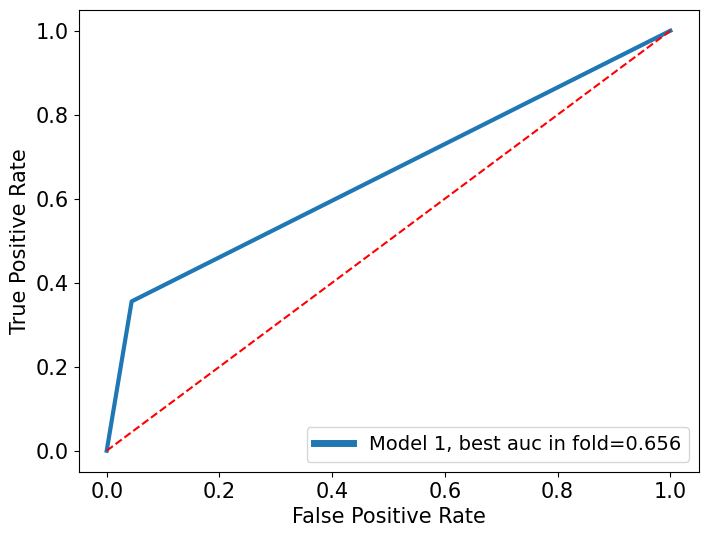

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(best_auc_rf[0],best_auc_rf[1],label="{}, best auc in fold={:.3f}".format("Model 1",best_auc_rf[2]),linewidth=3)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
leg = plt.legend(loc="lower right", prop={'size': 14})
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
plt.show()

## XGBoost

### HPTuning

In [ ]:
def Objective_XGB(trial):
  params_xgb = dict(n_estimators = trial.suggest_int('n_estimators', 100, 1000),
                    max_depth = trial.suggest_int('max_depth', 1, 100),
                    objective = trial.suggest_categorical('objective',['binary:logistic', 'binary:logitraw', 'binary:hinge']),
                    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1, log=True),
                    subsample = trial.suggest_float('subsample', 0, 1),
                    eval_metric = 'auc',
                    seed = 42,
                    )
  np.random.seed(42)
  cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
  res_all_xgb = [[],[],[],[],[]]
  auc_plots_xgb = []
  countcv = 1
  for train_ix, test_ix in cv.split(X, Y):
      #Bagi data menjadi train, test
      print("K-Fold ke :", countcv)
      countcv+=1
      X_train, X_test = X.iloc[train_ix,:], X.iloc[test_ix,:]
      y_train, y_test = Y[train_ix], Y[test_ix]
      # latih model
      model_xgb = xgb.XGBClassifier(**params_xgb)
      model_xgb.fit(X_train, y_train)
      # Prediksi test
      yhat = model_xgb.predict(X_test)
      # Bulatkan hasil prediksi (probabilitas)
      yhat = yhat.round()
      # Hitung metrik
      #Calculate metrics
      accu = accuracy_score(y_test, yhat)
      auc = roc_auc_score(y_test, yhat)
      precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(yhat, y_test, average='binary',pos_label=1, labels=model_xgb.classes_)
      _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)

      res_all_xgb[0].append(accu);res_all_xgb[1].append(recall_score);res_all_xgb[2].append(precision_score);res_all_xgb[3].append(auc);res_all_xgb[4].append(f1_score)

  return np.mean(res_all_xgb[3])


In [ ]:
study = optuna.create_study(direction="maximize", study_name='XGB optimization')
study.optimize(Objective_XGB, n_trials=100)

[I 2023-11-15 18:05:11,813] A new study created in memory with name: XGB optimization


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 18:21:50,639] Trial 0 finished with value: 0.6442699385177261 and parameters: {'n_estimators': 982, 'max_depth': 39, 'objective': 'binary:hinge', 'learning_rate': 0.0017087921490061763, 'subsample': 0.3237135925280916}. Best is trial 0 with value: 0.6442699385177261.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 18:27:00,887] Trial 1 finished with value: 0.6345079797292186 and parameters: {'n_estimators': 498, 'max_depth': 76, 'objective': 'binary:logistic', 'learning_rate': 0.052851675364626635, 'subsample': 0.9328826348169674}. Best is trial 0 with value: 0.6442699385177261.


K-Fold ke : 1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-Fold ke : 2


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-Fold ke : 3


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-Fold ke : 4


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-Fold ke : 5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-15 18:29:03,050] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 179, 'max_depth': 8, 'objective': 'binary:logitraw', 'learning_rate': 0.001776998286564994, 'subsample': 0.6267410068571441}. Best is trial 0 with value: 0.6442699385177261.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 18:41:55,981] Trial 3 finished with value: 0.5813842696143581 and parameters: {'n_estimators': 988, 'max_depth': 63, 'objective': 'binary:logistic', 'learning_rate': 0.002344300480845716, 'subsample': 0.5365751479857442}. Best is trial 0 with value: 0.6442699385177261.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 18:45:04,833] Trial 4 finished with value: 0.6461951224783083 and parameters: {'n_estimators': 549, 'max_depth': 36, 'objective': 'binary:logistic', 'learning_rate': 0.4529272839565727, 'subsample': 0.8894144920797935}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 18:50:31,074] Trial 5 finished with value: 0.6371044982549408 and parameters: {'n_estimators': 780, 'max_depth': 56, 'objective': 'binary:logistic', 'learning_rate': 0.09015374588404616, 'subsample': 0.3808579461929128}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 18:58:50,699] Trial 6 finished with value: 0.6251862837261067 and parameters: {'n_estimators': 644, 'max_depth': 30, 'objective': 'binary:logistic', 'learning_rate': 0.015193187721801256, 'subsample': 0.7187450670101944}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 19:01:54,196] Trial 7 finished with value: 0.5902020054674922 and parameters: {'n_estimators': 607, 'max_depth': 97, 'objective': 'binary:hinge', 'learning_rate': 0.3807325727576645, 'subsample': 0.09071688177463433}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 19:07:02,079] Trial 8 finished with value: 0.5042108334143733 and parameters: {'n_estimators': 440, 'max_depth': 61, 'objective': 'binary:hinge', 'learning_rate': 0.0012057228682569579, 'subsample': 0.17110893231266688}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 19:09:08,544] Trial 9 finished with value: 0.6379945325078069 and parameters: {'n_estimators': 396, 'max_depth': 5, 'objective': 'binary:logitraw', 'learning_rate': 0.5548732930763532, 'subsample': 0.6283272481780875}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 19:10:29,691] Trial 10 finished with value: 0.6263124682593708 and parameters: {'n_estimators': 214, 'max_depth': 29, 'objective': 'binary:logistic', 'learning_rate': 0.9720893237091818, 'subsample': 0.97195011824995}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 19:21:25,849] Trial 11 finished with value: 0.6378562244048969 and parameters: {'n_estimators': 982, 'max_depth': 37, 'objective': 'binary:hinge', 'learning_rate': 0.009741189011667744, 'subsample': 0.3406702399129379}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 19:32:53,997] Trial 12 finished with value: 0.627620074124499 and parameters: {'n_estimators': 812, 'max_depth': 38, 'objective': 'binary:hinge', 'learning_rate': 0.0054948740847617136, 'subsample': 0.32002651234674856}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 19:38:08,126] Trial 13 finished with value: 0.6184067014597987 and parameters: {'n_estimators': 764, 'max_depth': 18, 'objective': 'binary:hinge', 'learning_rate': 0.11779583802826925, 'subsample': 0.8223180996497353}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 19:42:28,433] Trial 14 finished with value: 0.5846713021491783 and parameters: {'n_estimators': 349, 'max_depth': 47, 'objective': 'binary:logitraw', 'learning_rate': 0.021990508761551775, 'subsample': 0.4676982190617658}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 19:53:12,343] Trial 15 finished with value: 0.6072530714123634 and parameters: {'n_estimators': 655, 'max_depth': 77, 'objective': 'binary:logistic', 'learning_rate': 0.005681208455173311, 'subsample': 0.787137193724256}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 19:54:31,685] Trial 16 finished with value: 0.5265886522523691 and parameters: {'n_estimators': 301, 'max_depth': 23, 'objective': 'binary:hinge', 'learning_rate': 0.037936541644866914, 'subsample': 0.022552696131109218}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 19:59:21,217] Trial 17 finished with value: 0.6384714253298324 and parameters: {'n_estimators': 872, 'max_depth': 47, 'objective': 'binary:logistic', 'learning_rate': 0.2514293258405063, 'subsample': 0.24529265580419016}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 20:03:01,054] Trial 18 finished with value: 0.624499119366376 and parameters: {'n_estimators': 536, 'max_depth': 15, 'objective': 'binary:hinge', 'learning_rate': 0.14214462564152416, 'subsample': 0.44114296078507753}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 20:09:41,753] Trial 19 finished with value: 0.6138661436891526 and parameters: {'n_estimators': 704, 'max_depth': 41, 'objective': 'binary:logitraw', 'learning_rate': 0.037097136005180185, 'subsample': 0.5416691339392592}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 20:13:22,852] Trial 20 finished with value: 0.6356222784098889 and parameters: {'n_estimators': 488, 'max_depth': 29, 'objective': 'binary:hinge', 'learning_rate': 0.05938660672837848, 'subsample': 0.22439556082828238}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 20:17:59,868] Trial 21 finished with value: 0.6329280797864869 and parameters: {'n_estimators': 884, 'max_depth': 50, 'objective': 'binary:logistic', 'learning_rate': 0.2279812366382446, 'subsample': 0.25067747803988394}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 20:22:32,962] Trial 22 finished with value: 0.634841053734859 and parameters: {'n_estimators': 907, 'max_depth': 45, 'objective': 'binary:logistic', 'learning_rate': 0.23291390525128697, 'subsample': 0.2760434100310053}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 20:26:45,232] Trial 23 finished with value: 0.6337935319351248 and parameters: {'n_estimators': 873, 'max_depth': 72, 'objective': 'binary:logistic', 'learning_rate': 0.46224150071493963, 'subsample': 0.3991228114551637}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 20:31:48,270] Trial 24 finished with value: 0.6285326374706907 and parameters: {'n_estimators': 955, 'max_depth': 53, 'objective': 'binary:logistic', 'learning_rate': 0.2134891812672326, 'subsample': 0.1840555594227944}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 20:35:29,100] Trial 25 finished with value: 0.6247525581596378 and parameters: {'n_estimators': 718, 'max_depth': 34, 'objective': 'binary:logistic', 'learning_rate': 0.9299141514968762, 'subsample': 0.3280590889170651}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 20:39:51,376] Trial 26 finished with value: 0.6225120749457033 and parameters: {'n_estimators': 578, 'max_depth': 67, 'objective': 'binary:logistic', 'learning_rate': 0.08847688239496476, 'subsample': 0.4328616661494871}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 20:45:44,830] Trial 27 finished with value: 0.6055150356035311 and parameters: {'n_estimators': 844, 'max_depth': 88, 'objective': 'binary:logistic', 'learning_rate': 0.022879194554654123, 'subsample': 0.16131111302586346}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 20:49:45,161] Trial 28 finished with value: 0.6134739645801593 and parameters: {'n_estimators': 722, 'max_depth': 24, 'objective': 'binary:hinge', 'learning_rate': 0.3294473392761275, 'subsample': 0.2932094212476247}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 20:57:43,336] Trial 29 finished with value: 0.6236449047510995 and parameters: {'n_estimators': 938, 'max_depth': 42, 'objective': 'binary:logitraw', 'learning_rate': 0.0613969578010297, 'subsample': 0.8836580500604393}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 20:59:14,688] Trial 30 finished with value: 0.6247243022464262 and parameters: {'n_estimators': 104, 'max_depth': 57, 'objective': 'binary:logistic', 'learning_rate': 0.13043602854090489, 'subsample': 0.9091861119810578}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 21:01:20,684] Trial 31 finished with value: 0.6305039601499778 and parameters: {'n_estimators': 414, 'max_depth': 4, 'objective': 'binary:logitraw', 'learning_rate': 0.6102388700084639, 'subsample': 0.6343762274382292}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 21:04:20,136] Trial 32 finished with value: 0.6236499832517531 and parameters: {'n_estimators': 490, 'max_depth': 12, 'objective': 'binary:logitraw', 'learning_rate': 0.5170683888800668, 'subsample': 0.9786915430677015}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 21:05:14,379] Trial 33 finished with value: 0.5117018920116265 and parameters: {'n_estimators': 344, 'max_depth': 1, 'objective': 'binary:logitraw', 'learning_rate': 0.3142237189540747, 'subsample': 0.6025610020231582}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 21:07:47,131] Trial 34 finished with value: 0.6178541713939945 and parameters: {'n_estimators': 421, 'max_depth': 22, 'objective': 'binary:logitraw', 'learning_rate': 0.6721748094552057, 'subsample': 0.49049165464087263}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-Fold ke : 2


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-Fold ke : 3


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-Fold ke : 4


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-Fold ke : 5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-15 21:11:00,287] Trial 35 finished with value: 0.5 and parameters: {'n_estimators': 257, 'max_depth': 8, 'objective': 'binary:logitraw', 'learning_rate': 0.0023483206382064604, 'subsample': 0.7409678094521353}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 21:14:11,159] Trial 36 finished with value: 0.6276673474018607 and parameters: {'n_estimators': 562, 'max_depth': 34, 'objective': 'binary:logistic', 'learning_rate': 0.7566137023609197, 'subsample': 0.36729032627178304}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 21:19:15,049] Trial 37 finished with value: 0.6262831318141052 and parameters: {'n_estimators': 998, 'max_depth': 56, 'objective': 'binary:logitraw', 'learning_rate': 0.47383913720076903, 'subsample': 0.5266383237044977}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 21:23:04,983] Trial 38 finished with value: 0.6446732471068755 and parameters: {'n_estimators': 634, 'max_depth': 62, 'objective': 'binary:logistic', 'learning_rate': 0.3473943921749107, 'subsample': 0.7092360719504681}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 21:26:56,290] Trial 39 finished with value: 0.6435182123677698 and parameters: {'n_estimators': 640, 'max_depth': 61, 'objective': 'binary:logistic', 'learning_rate': 0.3427682675915011, 'subsample': 0.8705444091728867}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 21:30:44,264] Trial 40 finished with value: 0.6453663003663003 and parameters: {'n_estimators': 638, 'max_depth': 66, 'objective': 'binary:logistic', 'learning_rate': 0.37462289590335784, 'subsample': 0.8627301968056403}. Best is trial 4 with value: 0.6461951224783083.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 21:34:23,785] Trial 41 finished with value: 0.6471240018585152 and parameters: {'n_estimators': 625, 'max_depth': 64, 'objective': 'binary:logistic', 'learning_rate': 0.3759445907987205, 'subsample': 0.8425166476652832}. Best is trial 41 with value: 0.6471240018585152.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 21:37:56,036] Trial 42 finished with value: 0.6466376003544145 and parameters: {'n_estimators': 599, 'max_depth': 75, 'objective': 'binary:logistic', 'learning_rate': 0.43430633861070606, 'subsample': 0.9429185160700041}. Best is trial 41 with value: 0.6471240018585152.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 21:41:27,706] Trial 43 finished with value: 0.6470068181572607 and parameters: {'n_estimators': 612, 'max_depth': 81, 'objective': 'binary:logistic', 'learning_rate': 0.4312986534439228, 'subsample': 0.927400535690714}. Best is trial 41 with value: 0.6471240018585152.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 21:44:14,864] Trial 44 finished with value: 0.6530219780219779 and parameters: {'n_estimators': 516, 'max_depth': 83, 'objective': 'binary:logistic', 'learning_rate': 0.7526128254889318, 'subsample': 0.9477185950147595}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 21:46:47,541] Trial 45 finished with value: 0.6455119020605746 and parameters: {'n_estimators': 514, 'max_depth': 85, 'objective': 'binary:logistic', 'learning_rate': 0.937117009984575, 'subsample': 0.9980590576267517}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 21:49:21,058] Trial 46 finished with value: 0.6497179811339103 and parameters: {'n_estimators': 454, 'max_depth': 82, 'objective': 'binary:logistic', 'learning_rate': 0.6987095240060137, 'subsample': 0.9454419300882607}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 21:51:58,070] Trial 47 finished with value: 0.6430879445038736 and parameters: {'n_estimators': 454, 'max_depth': 81, 'objective': 'binary:logistic', 'learning_rate': 0.6271573999017916, 'subsample': 0.9381905989988274}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 21:55:00,170] Trial 48 finished with value: 0.6477097042583768 and parameters: {'n_estimators': 581, 'max_depth': 97, 'objective': 'binary:logistic', 'learning_rate': 0.7317655809952707, 'subsample': 0.948147438579633}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 21:58:30,602] Trial 49 finished with value: 0.6431294909613492 and parameters: {'n_estimators': 687, 'max_depth': 99, 'objective': 'binary:logistic', 'learning_rate': 0.7784677851482961, 'subsample': 0.9306630754318095}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 22:00:31,047] Trial 50 finished with value: 0.6402070839681459 and parameters: {'n_estimators': 369, 'max_depth': 89, 'objective': 'binary:logistic', 'learning_rate': 0.9897162870667054, 'subsample': 0.8410706366306016}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 22:03:47,384] Trial 51 finished with value: 0.6448603952586254 and parameters: {'n_estimators': 590, 'max_depth': 74, 'objective': 'binary:logistic', 'learning_rate': 0.5314070615853987, 'subsample': 0.9421230132825982}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 22:06:45,637] Trial 52 finished with value: 0.6411430948599091 and parameters: {'n_estimators': 530, 'max_depth': 90, 'objective': 'binary:logistic', 'learning_rate': 0.6668508042533043, 'subsample': 0.9511415125556574}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 22:09:35,429] Trial 53 finished with value: 0.6420061698380282 and parameters: {'n_estimators': 456, 'max_depth': 94, 'objective': 'binary:logistic', 'learning_rate': 0.4333805303253878, 'subsample': 0.8981047423989275}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 22:13:47,086] Trial 54 finished with value: 0.6440119074632349 and parameters: {'n_estimators': 611, 'max_depth': 79, 'objective': 'binary:logistic', 'learning_rate': 0.1885271321449683, 'subsample': 0.9862036933517614}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 22:17:22,399] Trial 55 finished with value: 0.6459713442899284 and parameters: {'n_estimators': 551, 'max_depth': 70, 'objective': 'binary:logistic', 'learning_rate': 0.289886942351198, 'subsample': 0.9111137853056741}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 22:21:06,453] Trial 56 finished with value: 0.6484344711335861 and parameters: {'n_estimators': 675, 'max_depth': 83, 'objective': 'binary:logistic', 'learning_rate': 0.43408347847854994, 'subsample': 0.8156962782108566}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 22:25:00,679] Trial 57 finished with value: 0.6320722983997321 and parameters: {'n_estimators': 779, 'max_depth': 84, 'objective': 'binary:logistic', 'learning_rate': 0.7593323767932892, 'subsample': 0.8133327517269012}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 22:28:41,017] Trial 58 finished with value: 0.6426625930608231 and parameters: {'n_estimators': 678, 'max_depth': 94, 'objective': 'binary:logistic', 'learning_rate': 0.5761432462690491, 'subsample': 0.8498151101867075}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 22:33:36,358] Trial 59 finished with value: 0.6404573351918484 and parameters: {'n_estimators': 746, 'max_depth': 83, 'objective': 'binary:logistic', 'learning_rate': 0.17618222784971949, 'subsample': 0.8004921171065484}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 22:36:54,943] Trial 60 finished with value: 0.6389135790463223 and parameters: {'n_estimators': 482, 'max_depth': 93, 'objective': 'binary:logistic', 'learning_rate': 0.27188456161740016, 'subsample': 0.8892124879340345}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 22:40:29,404] Trial 61 finished with value: 0.6345008482176624 and parameters: {'n_estimators': 604, 'max_depth': 76, 'objective': 'binary:logistic', 'learning_rate': 0.46326715832823656, 'subsample': 0.9670398834758812}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 22:43:59,231] Trial 62 finished with value: 0.6441697191697192 and parameters: {'n_estimators': 565, 'max_depth': 78, 'objective': 'binary:logistic', 'learning_rate': 0.40504506546603086, 'subsample': 0.9206745597295626}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 22:48:14,269] Trial 63 finished with value: 0.641563529882114 and parameters: {'n_estimators': 667, 'max_depth': 69, 'objective': 'binary:logistic', 'learning_rate': 0.2658489254117677, 'subsample': 0.962434212033709}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 22:51:23,645] Trial 64 finished with value: 0.6353785103785103 and parameters: {'n_estimators': 519, 'max_depth': 73, 'objective': 'binary:logistic', 'learning_rate': 0.4047571391243788, 'subsample': 0.9978679802678889}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 22:54:37,180] Trial 65 finished with value: 0.6376058111013864 and parameters: {'n_estimators': 619, 'max_depth': 87, 'objective': 'binary:logistic', 'learning_rate': 0.7756056801979362, 'subsample': 0.8327470423775534}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 22:58:28,340] Trial 66 finished with value: 0.6298207397322442 and parameters: {'n_estimators': 743, 'max_depth': 100, 'objective': 'binary:logistic', 'learning_rate': 0.99169736956046, 'subsample': 0.9012056213022557}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 23:02:01,120] Trial 67 finished with value: 0.6182532118815305 and parameters: {'n_estimators': 582, 'max_depth': 80, 'objective': 'binary:hinge', 'learning_rate': 0.5215844957213043, 'subsample': 0.8535896349626872}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 23:05:57,695] Trial 68 finished with value: 0.6346513663327823 and parameters: {'n_estimators': 700, 'max_depth': 65, 'objective': 'binary:logistic', 'learning_rate': 0.6528865796433937, 'subsample': 0.9454482114474053}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 23:10:52,855] Trial 69 finished with value: 0.6450645077636228 and parameters: {'n_estimators': 798, 'max_depth': 92, 'objective': 'binary:logistic', 'learning_rate': 0.29323549002747096, 'subsample': 0.884532651818419}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 23:14:49,878] Trial 70 finished with value: 0.6519352869352869 and parameters: {'n_estimators': 660, 'max_depth': 97, 'objective': 'binary:logistic', 'learning_rate': 0.39542338842538416, 'subsample': 0.9664366429985267}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 23:18:49,460] Trial 71 finished with value: 0.6386385836385836 and parameters: {'n_estimators': 662, 'max_depth': 97, 'objective': 'binary:logistic', 'learning_rate': 0.39725679703395544, 'subsample': 0.9658831675169542}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 23:22:06,403] Trial 72 finished with value: 0.6395796730310005 and parameters: {'n_estimators': 549, 'max_depth': 86, 'objective': 'binary:logistic', 'learning_rate': 0.5532187332771878, 'subsample': 0.9234928518069107}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 23:26:15,293] Trial 73 finished with value: 0.6439703610057592 and parameters: {'n_estimators': 593, 'max_depth': 82, 'objective': 'binary:logistic', 'learning_rate': 0.23051009337187126, 'subsample': 0.8770292952053129}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 23:29:16,894] Trial 74 finished with value: 0.6402532226868509 and parameters: {'n_estimators': 467, 'max_depth': 96, 'objective': 'binary:logistic', 'learning_rate': 0.342754341812028, 'subsample': 0.7821028164680843}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 23:32:21,862] Trial 75 finished with value: 0.6408363858363858 and parameters: {'n_estimators': 498, 'max_depth': 91, 'objective': 'binary:logistic', 'learning_rate': 0.4724606822466091, 'subsample': 0.9651139309684984}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 23:35:45,641] Trial 76 finished with value: 0.648424800371703 and parameters: {'n_estimators': 624, 'max_depth': 75, 'objective': 'binary:logistic', 'learning_rate': 0.8104743304300716, 'subsample': 0.9129037532462315}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 23:39:12,204] Trial 77 finished with value: 0.6194501172377279 and parameters: {'n_estimators': 631, 'max_depth': 69, 'objective': 'binary:hinge', 'learning_rate': 0.8391290450461412, 'subsample': 0.9986930055075882}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 23:43:08,435] Trial 78 finished with value: 0.6455168184814203 and parameters: {'n_estimators': 725, 'max_depth': 88, 'objective': 'binary:logistic', 'learning_rate': 0.6721456043015028, 'subsample': 0.9108436137455027}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 23:46:40,780] Trial 79 finished with value: 0.6380067425200168 and parameters: {'n_estimators': 665, 'max_depth': 77, 'objective': 'binary:logistic', 'learning_rate': 0.8489273356150824, 'subsample': 0.8650248161978208}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 23:49:04,651] Trial 80 finished with value: 0.6435719688374556 and parameters: {'n_estimators': 392, 'max_depth': 58, 'objective': 'binary:logistic', 'learning_rate': 0.5585883821389566, 'subsample': 0.839868697907803}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 23:52:18,497] Trial 81 finished with value: 0.6377707543194269 and parameters: {'n_estimators': 576, 'max_depth': 75, 'objective': 'binary:logistic', 'learning_rate': 0.7299025856705053, 'subsample': 0.9318391985197696}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 23:55:55,900] Trial 82 finished with value: 0.6477242914411055 and parameters: {'n_estimators': 612, 'max_depth': 72, 'objective': 'binary:logistic', 'learning_rate': 0.47718892225464415, 'subsample': 0.9481389224610096}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-15 23:59:46,232] Trial 83 finished with value: 0.6429082520232963 and parameters: {'n_estimators': 695, 'max_depth': 81, 'objective': 'binary:logistic', 'learning_rate': 0.5887307899027429, 'subsample': 0.9782504645704366}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-16 00:03:49,904] Trial 84 finished with value: 0.6375445989605282 and parameters: {'n_estimators': 648, 'max_depth': 84, 'objective': 'binary:logistic', 'learning_rate': 0.32644392711478626, 'subsample': 0.8969296738777488}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-16 00:06:47,925] Trial 85 finished with value: 0.6304770008752311 and parameters: {'n_estimators': 541, 'max_depth': 70, 'objective': 'binary:logistic', 'learning_rate': 0.876492909171313, 'subsample': 0.9487717520737388}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-16 00:10:17,159] Trial 86 finished with value: 0.6324756069888814 and parameters: {'n_estimators': 619, 'max_depth': 72, 'objective': 'binary:logistic', 'learning_rate': 0.4971058305158758, 'subsample': 0.877530265327778}. Best is trial 44 with value: 0.6530219780219779.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-16 00:13:26,875] Trial 87 finished with value: 0.6543909581077723 and parameters: {'n_estimators': 513, 'max_depth': 64, 'objective': 'binary:logistic', 'learning_rate': 0.3760674530242582, 'subsample': 0.8253520839713084}. Best is trial 87 with value: 0.6543909581077723.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-16 00:15:57,041] Trial 88 finished with value: 0.6437835370136253 and parameters: {'n_estimators': 439, 'max_depth': 52, 'objective': 'binary:logistic', 'learning_rate': 0.6960285452154188, 'subsample': 0.8238552657595494}. Best is trial 87 with value: 0.6543909581077723.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-16 00:18:51,044] Trial 89 finished with value: 0.6101918484661847 and parameters: {'n_estimators': 516, 'max_depth': 67, 'objective': 'binary:hinge', 'learning_rate': 0.6159826391006163, 'subsample': 0.7768635600494818}. Best is trial 87 with value: 0.6543909581077723.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-16 00:22:19,092] Trial 90 finished with value: 0.6404427480091197 and parameters: {'n_estimators': 563, 'max_depth': 65, 'objective': 'binary:logistic', 'learning_rate': 0.3700991353519822, 'subsample': 0.8695902792222243}. Best is trial 87 with value: 0.6543909581077723.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-16 00:25:54,874] Trial 91 finished with value: 0.6366913568241002 and parameters: {'n_estimators': 622, 'max_depth': 60, 'objective': 'binary:logistic', 'learning_rate': 0.442491630611738, 'subsample': 0.9220896857061396}. Best is trial 87 with value: 0.6543909581077723.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-16 00:29:58,253] Trial 92 finished with value: 0.642638010956595 and parameters: {'n_estimators': 650, 'max_depth': 72, 'objective': 'binary:logistic', 'learning_rate': 0.2916592370460287, 'subsample': 0.9798238887769053}. Best is trial 87 with value: 0.6543909581077723.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-16 00:32:35,565] Trial 93 finished with value: 0.6382206878667055 and parameters: {'n_estimators': 476, 'max_depth': 63, 'objective': 'binary:logistic', 'learning_rate': 0.996846364563914, 'subsample': 0.9066561512049582}. Best is trial 87 with value: 0.6543909581077723.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-16 00:35:24,310] Trial 94 finished with value: 0.6335524652338811 and parameters: {'n_estimators': 505, 'max_depth': 80, 'objective': 'binary:logistic', 'learning_rate': 0.7819444783993562, 'subsample': 0.948061648149547}. Best is trial 87 with value: 0.6543909581077723.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-16 00:39:05,301] Trial 95 finished with value: 0.6380262461235912 and parameters: {'n_estimators': 674, 'max_depth': 78, 'objective': 'binary:logistic', 'learning_rate': 0.5136203540789611, 'subsample': 0.8124028508513794}. Best is trial 87 with value: 0.6543909581077723.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-16 00:42:22,004] Trial 96 finished with value: 0.6419425805266513 and parameters: {'n_estimators': 538, 'max_depth': 85, 'objective': 'binary:logistic', 'learning_rate': 0.3877118515358814, 'subsample': 0.9304220461042795}. Best is trial 87 with value: 0.6543909581077723.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-16 00:46:20,424] Trial 97 finished with value: 0.6375541076426032 and parameters: {'n_estimators': 596, 'max_depth': 96, 'objective': 'binary:logitraw', 'learning_rate': 0.25705379355503827, 'subsample': 0.8456649513472068}. Best is trial 87 with value: 0.6543909581077723.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-16 00:50:17,140] Trial 98 finished with value: 0.6492804196786498 and parameters: {'n_estimators': 719, 'max_depth': 90, 'objective': 'binary:logistic', 'learning_rate': 0.6110735849862916, 'subsample': 0.891077114368659}. Best is trial 87 with value: 0.6543909581077723.


K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


[I 2023-11-16 00:54:08,085] Trial 99 finished with value: 0.6470558202859087 and parameters: {'n_estimators': 749, 'max_depth': 89, 'objective': 'binary:logistic', 'learning_rate': 0.8494668973571021, 'subsample': 0.8900506891170474}. Best is trial 87 with value: 0.6543909581077723.


### Train

In [ ]:
XGB_params = study.best_params
print(XGB_params)

{'n_estimators': 513, 'max_depth': 64, 'objective': 'binary:logistic', 'learning_rate': 0.3760674530242582, 'subsample': 0.8253520839713084}


In [ ]:
XGB_params = {'n_estimators': 513, 'max_depth': 64, 'objective': 'binary:logistic', 'learning_rate': 0.3760674530242582, 'subsample': 0.8253520839713084}

In [ ]:
XGB_used_params = dict(n_estimators=XGB_params['n_estimators'],
                       max_depth=XGB_params['max_depth'],
                       objective=XGB_params['objective'],
                       learning_rate=XGB_params['learning_rate'],
                       subsample=XGB_params['subsample'],
                       eval_metric='auc',
                       seed=42
                       )

In [ ]:
np.random.seed(42)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
res_all_xgb = [[],[],[],[],[]]
auc_plots_xgb = []
countcv = 1
for train_ix, test_ix in cv.split(X, Y):
    #Bagi data menjadi train, test
    print("K-Fold ke :", countcv)
    countcv+=1
    X_train, X_test = X.iloc[train_ix,:], X.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]
    # latih model
    model_xgb = xgb.XGBClassifier(**XGB_used_params)
    model_xgb.fit(X_train, y_train)
    # Prediksi test
    yhat = model_xgb.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(yhat, y_test, average='binary',pos_label=1, labels=model_xgb.classes_)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)

    res_all_xgb[0].append(accu);res_all_xgb[1].append(recall_score);res_all_xgb[2].append(precision_score);res_all_xgb[3].append(auc);res_all_xgb[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat)
    auc_plots_xgb.append([fpr,tpr,auc])

K-Fold ke : 1
K-Fold ke : 2
K-Fold ke : 3
K-Fold ke : 4
K-Fold ke : 5


In [ ]:
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all_xgb[0]), np.std(res_all_xgb[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all_xgb[1]), np.std(res_all_xgb[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all_xgb[2]), np.std(res_all_xgb[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all_xgb[3]), np.std(res_all_xgb[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all_xgb[4]), np.std(res_all_xgb[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_xgb = auc_plots_xgb[np.array(res_all_xgb[3]).argmax()]
confusion_matrix_xgb = confusion_matrix(y_test,yhat)

#save model
#model_xgb.save("XGB_1to5_noFS_noSMOTE_OptunaHPTuning_100trials.h5")

Average Result of 5 CV
Accuracy    : 0.85176±0.008
Recall      : 0.59538±0.052
Precision   : 0.35834±0.027
ROC-AUC     : 0.65439±0.012
F1 Score    : 0.44601±0.024
[[428  24]
 [ 60  30]]


# Deep Learning

## DNN

In [ ]:
model_dnn = Sequential([
    Dense(512, activation='relu', input_shape=(x_train.shape[1],)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_dnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dnn.fit(x_train, y_train, epochs=100, verbose=1)

Epoch 1/100
69/69 [==============================] - 9s 6ms/step - loss: 0.7088 - accuracy: 0.6302
Epoch 2/100
69/69 [==============================] - 0s 6ms/step - loss: 0.5922 - accuracy: 0.7278
Epoch 3/100
69/69 [==============================] - 0s 6ms/step - loss: 0.5234 - accuracy: 0.7654
Epoch 4/100
69/69 [==============================] - 0s 6ms/step - loss: 0.5169 - accuracy: 0.7553
Epoch 5/100
69/69 [==============================] - 0s 6ms/step - loss: 0.4995 - accuracy: 0.7621
Epoch 6/100
69/69 [==============================] - 0s 6ms/step - loss: 0.4861 - accuracy: 0.7686
Epoch 7/100
69/69 [==============================] - 0s 6ms/step - loss: 0.4724 - accuracy: 0.7828
Epoch 8/100
69/69 [==============================] - 0s 6ms/step - loss: 0.4653 - accuracy: 0.7851
Epoch 9/100
69/69 [==============================] - 0s 6ms/step - loss: 0.4612 - accuracy: 0.7791
Epoch 10/100
69/69 [==============================] - 0s 6ms/step - loss: 0.4491 - accuracy: 0.7892
Epoch 11/

In [ ]:
test_loss, test_accuracy = model_dnn.evaluate(x_test, y_test, verbose=1)
print('Test loss sebesar :', test_loss)
print('Test accuracy sebesar : ', test_accuracy)

12/12 [==============================] - 0s 4ms/step - loss: 1.7675 - accuracy: 0.7238
Test loss sebesar : 1.7674516439437866
Test accuracy sebesar :  0.7237569093704224


## CNN

Membuat model machine learning menggunakan CNN

In [ ]:
def cnn_model(n_layers, hl_node, lr, do, fr_node=0.5, kernel_size=2, pool_size=2, input_shape=None):
    # Add input layer
    model_cnn = Sequential([Input(input_shape)])

    # Add additional convolutional layers
    for i in range(1, n_layers):
        filter = int(hl_node*(fr_node**n_layers))
        model_cnn.add(Conv1D(filter, kernel_size=kernel_size, activation='relu'))
        model_cnn.add(MaxPooling1D(pool_size=pool_size))
        model_cnn.add(Dropout(do))

    model_cnn.add(Flatten())
    model_cnn.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model_cnn.compile(optimizer=Adam(lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model_cnn

### HPTuning

In [ ]:
def Objective_CNN(trial):
  params_cnn = dict(n_layers = trial.suggest_int('n_layers', 1, 6),
                    hl_node = trial.suggest_int('hl_node', 128, 1024, step=8),
                    lr = trial.suggest_float('lr', 1e-5, 0.1, log=True),
                    do = trial.suggest_float('do', 0., 0.7)
                    )
  epochs = trial.suggest_int('epochs', 10, 100)
  batch_size = trial.suggest_int('batch_size', 8, 128, step=2)

  np.random.seed(123)
  cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
  res_all_cnn = [[],[],[],[],[]]
  auc_plots = []
  countcv = 1
  for train_ix, test_ix in cv.split(X, Y):
    #Bagi data menjadi train, test
    print("K-Fold ke :", countcv)
    countcv+=1
    X_train, X_test = X.iloc[train_ix,:], X.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]
    # latih model
    model_cnn = cnn_model(**params_cnn, input_shape=(X_train.shape[1], 1))
    model_cnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
    # Prediksi test
    yhat = model_cnn.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(yhat, y_test, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)

    res_all_cnn[0].append(accu);res_all_cnn[1].append(recall_score);res_all_cnn[2].append(precision_score);res_all_cnn[3].append(auc);res_all_cnn[4].append(f1_score)

  return np.mean(res_all_cnn[3])

In [ ]:
study = optuna.create_study(direction="maximize", study_name='CNN optimization')
study.optimize(Objective_CNN, n_trials=100)

[I 2024-01-08 18:27:20,334] A new study created in memory with name: CNN optimization


K-Fold ke : 1
17/17 [==============================] - 0s 18ms/step
K-Fold ke : 2
17/17 [==============================] - 0s 19ms/step
K-Fold ke : 3
17/17 [==============================] - 0s 17ms/step
K-Fold ke : 4
17/17 [==============================] - 0s 16ms/step
K-Fold ke : 5


[W 2024-01-08 18:42:06,113] Trial 0 failed with parameters: {'n_layers': 4, 'hl_node': 768, 'lr': 0.005253311130484205, 'do': 0.645450242800619, 'epochs': 32, 'batch_size': 70} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-18-b12657a3a4a2>", line 23, in Objective_CNN
    model_cnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return 

KeyboardInterrupt: 

### Train

In [ ]:
CNN_params = study.best_params
print(CNN_params)

{'n_layers': 1, 'hl_node': 856, 'lr': 0.006428422621179661, 'do': 0.4313130008029596, 'epochs': 31, 'batch_size': 106}


In [ ]:
CNN_used_params = {'n_layers': 1, 'hl_node': 856, 'lr': 0.006428422621179661, 'do': 0.4313130008029596, 'epochs': 31, 'batch_size': 106}

In [ ]:
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
res_all_cnn = [[],[],[],[],[]]
auc_plots_cnn = []
countcv = 1
for train_ix, test_ix in cv.split(X, Y):
  #Bagi data menjadi train, test
  print("K-Fold ke :", countcv)
  countcv+=1
  X_train, X_test = X.iloc[train_ix,:], X.iloc[test_ix,:]
  y_train, y_test = Y[train_ix], Y[test_ix]
  # latih model
  model_cnn = cnn_model(CNN_used_params.get('n_layers'), CNN_used_params.get('hl_node'), CNN_used_params.get('lr'), CNN_used_params.get('do'), input_shape=(X_train.shape[1], 1))
  model_cnn.fit(X_train, y_train, epochs=CNN_used_params.get('epochs'), batch_size=CNN_used_params.get('batch_size'), validation_data=(X_test, y_test), verbose=0)
  # Prediksi test
  yhat = model_cnn.predict(X_test)
  # Bulatkan hasil prediksi (probabilitas)
  yhat = yhat.round()
  # Hitung metrik
  #Calculate metrics
  accu = accuracy_score(y_test, yhat)
  auc = roc_auc_score(y_test, yhat)
  precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(yhat, y_test, average='binary',pos_label=1)
  _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)

  res_all_cnn[0].append(accu);res_all_cnn[1].append(recall_score);res_all_cnn[2].append(precision_score);res_all_cnn[3].append(auc);res_all_cnn[4].append(f1_score)
  fpr, tpr, _ = roc_curve(y_test,  yhat)
  auc_plots_cnn.append([fpr,tpr,auc])

K-Fold ke : 1
17/17 [==============================] - 0s 2ms/step
K-Fold ke : 2
17/17 [==============================] - 0s 2ms/step
K-Fold ke : 3
17/17 [==============================] - 0s 2ms/step
K-Fold ke : 4
17/17 [==============================] - 0s 2ms/step
K-Fold ke : 5
17/17 [==============================] - 0s 2ms/step


In [ ]:
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all_cnn[0]), np.std(res_all_cnn[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all_cnn[1]), np.std(res_all_cnn[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all_cnn[2]), np.std(res_all_cnn[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all_cnn[3]), np.std(res_all_cnn[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all_cnn[4]), np.std(res_all_cnn[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_cnn = auc_plots_cnn[np.array(res_all_cnn[3]).argmax()]
confusion_matrix_cnn = confusion_matrix(y_test,yhat)

#save model
model_cnn.save('CNN_1to5_noFS_noSMOTE_OptunaHPTuning_100trials.h5')

Average Result of 5 CV
Accuracy    : 0.75404±0.026
Recall      : 0.19039±0.057
Precision   : 0.13719±0.028
ROC-AUC     : 0.50731±0.024
F1 Score    : 0.15818±0.037
[[387  65]
 [ 77  13]]


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<ipython-input-62-5396e55a5c42>:9: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in leg.legendHandles:


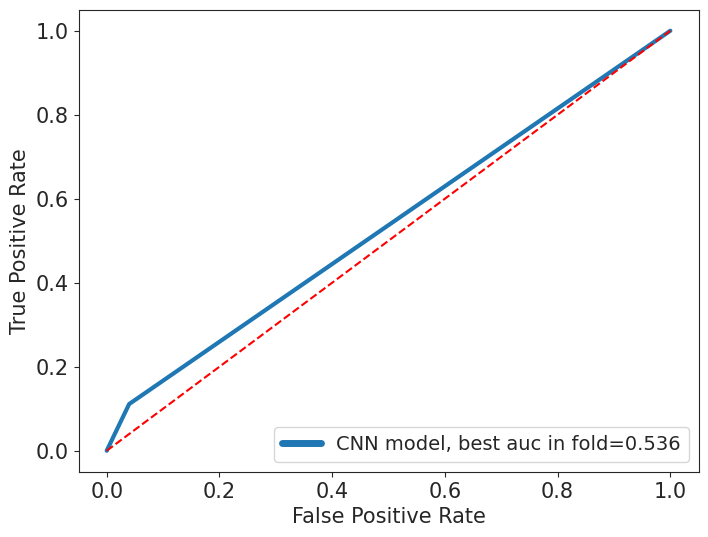

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(best_auc_cnn[0],best_auc_cnn[1],label="{}, best auc in fold={:.3f}".format("CNN model",best_auc_cnn[2]),linewidth=3)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
leg = plt.legend(loc="lower right", prop={'size': 14})
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
plt.show()

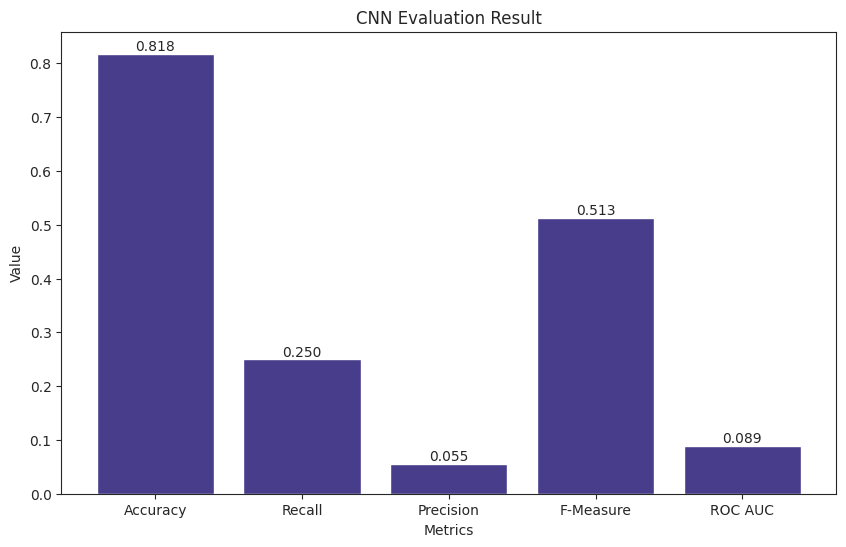

In [ ]:
avg_accuracy = np.mean(res_all_cnn[0])
avg_recall = np.mean(res_all_cnn[1])
avg_precision = np.mean(res_all_cnn[2])
avg_roc_auc = np.mean(res_all_cnn[3])
avg_f_measure = np.mean(res_all_cnn[4])

metric_names = ['Accuracy', 'Recall', 'Precision', 'ROC AUC',  'F-Measure']
average_values_cnn = [avg_accuracy, avg_recall, avg_precision, avg_roc_auc, avg_f_measure]

plt.figure(figsize=(10, 6))
bars = plt.bar(metric_names, average_values_cnn, color='darkslateblue')
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('CNN Evaluation Result')

# Annotate the bars with numeric values
for bar, value in zip(bars, average_values_cnn):
    plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.3f}', ha='center', va='bottom')

plt.show()

## SAE-DNN

In [ ]:
#Fungsi model SAE
def sae_model(xt, xv = None, EPOCHS = 100,BATCH_SIZE = 32,
              hl_node = 1024, lr = 0.01,af = "relu",num_layers = 3, do=0.5, fr_node = 0.5,
              verbose = 0,return_fe = False):
  #Setting result placeholders
  xt_ae = [] ;xv_ae = [] ; w_ae = []
  #If validation set is not present, use train set as validation set
  if xv is None :
    xv = xt.copy()
  #opt = tf.keras.optimizers.get(opt) #Set optimizer
  #opt.learning_rate.assign(lr)
  #K.set_value(opt.learning_rate, lr) #Set learning rate
  opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr)

  #Stacked Autoencoder architecture
  for n_layers in range(num_layers):
    #Autoencoder
    inp = Input(shape=(xt.shape[1],))
    #Apply Dropout
    hidden_layer = Dropout(do)(inp)
    #Layer encoder (jumlah layer sesuai dengan n_layers)
    enc = Dense(int(hl_node*(fr_node**n_layers)), activation = af)(hidden_layer)
    #Layer Decoder
    dec = Dense(xt.shape[1],activation="linear")(enc)
    ae = Model(inp, dec)
    #Compile model
    ae.compile(optimizer=opt, loss='mean_squared_error')
    #EarlyStop jika sudah konvergen
    es = EarlyStopping(monitor='val_loss', patience=15, verbose=verbose)
    #Latih model
    ae.fit(xt, xt,
           epochs=EPOCHS,batch_size=BATCH_SIZE,
           shuffle=True, callbacks = [es] , verbose = verbose,
           validation_data = (xv,xv))
    #Ekstrak Feature extraction
    fe = Model(ae.input, enc)
    #Simpan data hasil latih
    xt = fe.predict(xt) ; xt_ae.append(xt)
    xv = fe.predict(xv) ; xv_ae.append(xv)
    #Simpan bobot hasil latih SAE
    w_ae.append([layer_name for layer_name in ae.layers if "dense" in layer_name.name][0].get_weights())
    if verbose:
      print("Layer {} trained".format(n_layers+1))

  return (w_ae,xv) if return_fe else w_ae

#Fungsi DNN
def dnn_model(xt, n_outputs = 1, sae_weights = None, EPOCHS = 100,BATCH_SIZE = 32, opt = "adam",
              hl_node = 1024, lr = 0.01,af = "relu",num_layers = 3, do=0.5, fr_node = 0.5):
  opt = tf.keras.optimizers.get(opt) #Set optimizer
  K.set_value(opt.learning_rate, lr) #Set learning rate

  #Model architecture
  input_layer = Input(shape=(xt.shape[1],))
  hidden_layer = BatchNormalization()(input_layer)
  hidden_layer = Dropout(do)(hidden_layer)
#Set jumlah hidden layer
  for n_layers in range(num_layers):
    hidden_layer = Dense(int(hl_node*(fr_node**n_layers)), activation = af)(hidden_layer)
    hidden_layer = BatchNormalization()(hidden_layer)
    hidden_layer = Dropout(do)(hidden_layer)
  output_layer = Dense(n_outputs, activation = 'sigmoid')(hidden_layer)
#latih model
  dnn = Model(input_layer, output_layer)

  #Latih model DNN dengan bobot SAE (jika bobot ada)|
  if sae_weights is not None:
    weights = sae_weights
    dnn_dense = [layer_name for layer_name in dnn.layers if "dense" in layer_name.name]
    for weight_from,weight_to in list(zip(weights,dnn_dense)):
      weight_to.set_weights(weight_from)

  #Compile model
  dnn.compile(optimizer=opt, loss='binary_crossentropy', metrics = [
               tf.keras.metrics.Precision(),
               tf.keras.metrics.Recall()],
               )
  return dnn

### HPTuning

In [ ]:
def Objective_SAE_DNN(trial):
  params_sae = dict(EPOCHS = trial.suggest_int('epochs', 10, 100),
                    BATCH_SIZE = trial.suggest_int('batch_size', 8, 48, step=2),
                    hl_node = trial.suggest_int('hl_node', 128, 1024, step=8),
                    lr = trial.suggest_float('lr', 1e-5, 0.1, log=True),
                    do = trial.suggest_float('do', 0., 0.7))

  #Train SAE-DNN
  #Variabel untuk simpan hasil
  res_all_sae = [[],[],[],[],[]]
  auc_plots_sae = []
  X_mm_sae = pd.DataFrame(data = MinMaxScaler().fit_transform(X), columns = X.columns)
  #Latih SAE
  print("finding sae weights....")
  ti0 = time.time()
  sae_weights = sae_model(xt = X_mm_sae, **params_sae)
  ti1 = time.time()
  print('done, processing time:', ti1-ti0)
  i=0
  t0 = time.time()
  #Inisialisasi CV
  np.random.seed(42)
  cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
  #Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
  for train_ix, test_ix in cv.split(X, Y):
      #Bagi data menjadi train, test
      X_train, X_test = X.iloc[train_ix,:], X.iloc[test_ix,:]
      y_train, y_test = Y[train_ix], Y[test_ix]
      scaler = MinMaxScaler()
      X_train = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
      X_test = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
      # (optional) Running SMOTE utk balancing
      #sm = SMOTE(random_state=42)
      #X_train, y_train = sm.fit_resample(X_train, y_train)
      '''
      print("SAE Weights :", sae_weights)
      print("Sum of X_train na :", X_train.isnull().sum().sum())
      print("Sum of X_test na :", X_test.isnull().sum().sum())
      print("Sum of y_train na :", y_train.isnull().sum().sum())
      print("Sum of y_test na :", y_test.isnull().sum().sum())
      '''
      # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
      model_sae_dnn = dnn_model(xt = X_train, sae_weights = sae_weights, **params_sae)
      # latih model
      model_sae_dnn.fit(X_train, y_train, verbose=False, epochs=100)
      # Prediksi test
      yhat = model_sae_dnn.predict(X_test)
      # Bulatkan hasil prediksi (probabilitas)
      yhat = yhat.round()
      # Hitung metrik
      '''
      print("Sum of X_test na :", X_test.isnull().sum().sum())
      print("Sum of y_test na :", y_test.isnull().sum().sum())
      print("Sum of yhat na :", np.isnan(yhat).sum())
      print(yhat)
      '''
      accu = accuracy_score(y_test, yhat)
      auc = roc_auc_score(y_test, yhat)
      precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
      _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)

      res_all_sae[0].append(accu);res_all_sae[1].append(recall_score);res_all_sae[2].append(precision_score);res_all_sae[3].append(auc);res_all_sae[4].append(f1_score)

  return np.mean(res_all_sae[3])

In [ ]:
study = optuna.create_study(direction="maximize", study_name='SAE-DNN optimization')
study.optimize(Objective_SAE_DNN, n_trials=60)

[I 2023-11-16 09:42:58,060] A new study created in memory with name: SAE-DNN optimization


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 36.119017601013184
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 09:47:13,819] Trial 0 finished with value: 0.6294761040336262 and parameters: {'epochs': 51, 'batch_size': 44, 'hl_node': 928, 'lr': 0.0046828825024556545, 'do': 0.6212289331940293}. Best is trial 0 with value: 0.6294761040336262.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 24.9100980758667
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 09:51:14,431] Trial 1 finished with value: 0.6006630144683243 and parameters: {'epochs': 83, 'batch_size': 40, 'hl_node': 1016, 'lr': 0.05363077688557692, 'do': 0.1566914933160433}. Best is trial 0 with value: 0.6294761040336262.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 25.25816249847412
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 09:55:13,040] Trial 2 finished with value: 0.6289286524684755 and parameters: {'epochs': 78, 'batch_size': 36, 'hl_node': 176, 'lr': 0.003789005463102322, 'do': 0.46985866638716195}. Best is trial 0 with value: 0.6294761040336262.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 18.12521505355835
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 09:59:06,157] Trial 3 finished with value: 0.5561971214626082 and parameters: {'epochs': 35, 'batch_size': 40, 'hl_node': 632, 'lr': 0.06775723888106748, 'do': 0.5373267631929559}. Best is trial 0 with value: 0.6294761040336262.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 14.705073595046997
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 10:02:54,641] Trial 4 finished with value: 0.6041511340183907 and parameters: {'epochs': 12, 'batch_size': 36, 'hl_node': 520, 'lr': 0.00016910734226031096, 'do': 0.5256355544202967}. Best is trial 0 with value: 0.6294761040336262.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 40.77560472488403
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 10:07:12,425] Trial 5 finished with value: 0.6313822706300583 and parameters: {'epochs': 47, 'batch_size': 42, 'hl_node': 232, 'lr': 0.00047544580699686334, 'do': 0.2961239812742589}. Best is trial 5 with value: 0.6313822706300583.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 42.04833793640137
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 10:11:28,616] Trial 6 finished with value: 0.6386492268793154 and parameters: {'epochs': 60, 'batch_size': 40, 'hl_node': 272, 'lr': 0.002826519528710692, 'do': 0.12069156660278611}. Best is trial 6 with value: 0.6386492268793154.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 25.943782329559326
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 10:15:24,394] Trial 7 finished with value: 0.6209846888607949 and parameters: {'epochs': 82, 'batch_size': 22, 'hl_node': 296, 'lr': 0.016418119781025062, 'do': 0.4937323418290851}. Best is trial 6 with value: 0.6386492268793154.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 88.80521941184998
17/17 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-16 10:20:26,191] Trial 8 finished with value: 0.5088376716695301 and parameters: {'epochs': 88, 'batch_size': 34, 'hl_node': 192, 'lr': 3.7625178822876543e-05, 'do': 0.6213759430368913}. Best is trial 6 with value: 0.6386492268793154.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 25.662346124649048
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 10:24:21,553] Trial 9 finished with value: 0.6410731844360164 and parameters: {'epochs': 45, 'batch_size': 46, 'hl_node': 752, 'lr': 0.0024147854807232095, 'do': 0.45286521691622195}. Best is trial 9 with value: 0.6410731844360164.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 66.59374117851257
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 10:29:04,594] Trial 10 finished with value: 0.6248180384021091 and parameters: {'epochs': 21, 'batch_size': 8, 'hl_node': 792, 'lr': 1.096373245624302e-05, 'do': 0.34365966616241833}. Best is trial 9 with value: 0.6410731844360164.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 40.350484132766724
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 10:33:14,117] Trial 11 finished with value: 0.6245114914583942 and parameters: {'epochs': 64, 'batch_size': 48, 'hl_node': 504, 'lr': 0.002251429990319273, 'do': 0.029998962722553257}. Best is trial 9 with value: 0.6410731844360164.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 62.94138145446777
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 10:37:49,775] Trial 12 finished with value: 0.6331498049639642 and parameters: {'epochs': 65, 'batch_size': 24, 'hl_node': 728, 'lr': 0.0009221646921485871, 'do': 0.23119011725347205}. Best is trial 9 with value: 0.6410731844360164.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 20.011818408966064
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 10:41:42,942] Trial 13 finished with value: 0.6372994262374793 and parameters: {'epochs': 36, 'batch_size': 48, 'hl_node': 368, 'lr': 0.00938881256200851, 'do': 0.4115861992628385}. Best is trial 9 with value: 0.6410731844360164.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 61.0218460559845
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 10:46:16,054] Trial 14 finished with value: 0.6388704658173684 and parameters: {'epochs': 99, 'batch_size': 30, 'hl_node': 416, 'lr': 0.001395650460969222, 'do': 0.0007302555281474277}. Best is trial 9 with value: 0.6410731844360164.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 143.3555097579956
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 10:52:11,041] Trial 15 finished with value: 0.63092774482155 and parameters: {'epochs': 96, 'batch_size': 14, 'hl_node': 440, 'lr': 0.0005520125701520611, 'do': 0.0031569854509135853}. Best is trial 9 with value: 0.6410731844360164.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 121.4051444530487
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 10:57:42,693] Trial 16 finished with value: 0.6362495272672264 and parameters: {'epochs': 100, 'batch_size': 26, 'hl_node': 640, 'lr': 0.00018475382790399507, 'do': 0.38478448413239763}. Best is trial 9 with value: 0.6410731844360164.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 41.819663286209106
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 11:01:58,574] Trial 17 finished with value: 0.626466011864242 and parameters: {'epochs': 38, 'batch_size': 30, 'hl_node': 816, 'lr': 0.0014175756301554009, 'do': 0.27252418630295855}. Best is trial 9 with value: 0.6410731844360164.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 32.90412449836731
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 11:06:03,280] Trial 18 finished with value: 0.564118555976963 and parameters: {'epochs': 73, 'batch_size': 20, 'hl_node': 400, 'lr': 0.00863778703435858, 'do': 0.698838237629882}. Best is trial 9 with value: 0.6410731844360164.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 22.829878568649292
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 11:09:57,443] Trial 19 finished with value: 0.6282774698261424 and parameters: {'epochs': 26, 'batch_size': 30, 'hl_node': 704, 'lr': 0.022278799340249837, 'do': 0.19515227573858868}. Best is trial 9 with value: 0.6410731844360164.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 66.18773102760315
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 11:14:40,144] Trial 20 finished with value: 0.6350873610165646 and parameters: {'epochs': 47, 'batch_size': 18, 'hl_node': 928, 'lr': 0.0014288592755682995, 'do': 0.1023582239707942}. Best is trial 9 with value: 0.6410731844360164.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 36.8192355632782
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 11:18:48,833] Trial 21 finished with value: 0.6211415280884307 and parameters: {'epochs': 60, 'batch_size': 46, 'hl_node': 352, 'lr': 0.003155220474006358, 'do': 0.07423937415728597}. Best is trial 9 with value: 0.6410731844360164.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 26.74091601371765
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 11:22:47,856] Trial 22 finished with value: 0.6502492787448538 and parameters: {'epochs': 72, 'batch_size': 34, 'hl_node': 272, 'lr': 0.005353369339157353, 'do': 0.11720777275661616}. Best is trial 22 with value: 0.6502492787448538.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 26.0109806060791
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 11:26:41,698] Trial 23 finished with value: 0.6350970317784478 and parameters: {'epochs': 72, 'batch_size': 34, 'hl_node': 128, 'lr': 0.008295976200708386, 'do': 0.05436304926981682}. Best is trial 22 with value: 0.6502492787448538.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 27.875648975372314
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 11:30:39,486] Trial 24 finished with value: 0.6406112029563357 and parameters: {'epochs': 92, 'batch_size': 30, 'hl_node': 480, 'lr': 0.005421825359030098, 'do': 0.14046554464276484}. Best is trial 22 with value: 0.6502492787448538.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 22.271801233291626
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 11:34:34,074] Trial 25 finished with value: 0.6242217467881185 and parameters: {'epochs': 92, 'batch_size': 28, 'hl_node': 560, 'lr': 0.02863338406174143, 'do': 0.16218966211517657}. Best is trial 22 with value: 0.6502492787448538.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 28.170472383499146
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 11:38:31,154] Trial 26 finished with value: 0.6260917155607421 and parameters: {'epochs': 73, 'batch_size': 34, 'hl_node': 480, 'lr': 0.004884971505739198, 'do': 0.22788948436096285}. Best is trial 22 with value: 0.6502492787448538.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 37.84250450134277
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 11:42:55,121] Trial 27 finished with value: 0.6223543172658218 and parameters: {'epochs': 88, 'batch_size': 16, 'hl_node': 616, 'lr': 0.012996377512905829, 'do': 0.11631409370704107}. Best is trial 22 with value: 0.6502492787448538.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 17.10135293006897
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 11:47:10,648] Trial 28 finished with value: 0.6477011680551503 and parameters: {'epochs': 53, 'batch_size': 44, 'hl_node': 304, 'lr': 0.03646500305236471, 'do': 0.3131050487528271}. Best is trial 22 with value: 0.6502492787448538.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 20.890390872955322
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 11:51:26,368] Trial 29 finished with value: 0.5969831004786756 and parameters: {'epochs': 52, 'batch_size': 42, 'hl_node': 880, 'lr': 0.033180308679454436, 'do': 0.3127172810958665}. Best is trial 22 with value: 0.6502492787448538.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 17.002379655838013
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 11:55:27,599] Trial 30 finished with value: 0.5684703988243811 and parameters: {'epochs': 42, 'batch_size': 44, 'hl_node': 312, 'lr': 0.0703947191235648, 'do': 0.38178810168853794}. Best is trial 22 with value: 0.6502492787448538.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 17.876774549484253
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 11:59:25,687] Trial 31 finished with value: 0.6319359352545193 and parameters: {'epochs': 59, 'batch_size': 46, 'hl_node': 336, 'lr': 0.005128979848784107, 'do': 0.22912559017122835}. Best is trial 22 with value: 0.6502492787448538.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 18.073938131332397
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 12:03:23,936] Trial 32 finished with value: 0.6300672090937577 and parameters: {'epochs': 53, 'batch_size': 44, 'hl_node': 456, 'lr': 0.03919793158256852, 'do': 0.1603672623770773}. Best is trial 22 with value: 0.6502492787448538.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 29.335201740264893
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 12:07:32,497] Trial 33 finished with value: 0.6179970717581337 and parameters: {'epochs': 78, 'batch_size': 38, 'hl_node': 992, 'lr': 0.016990808253052696, 'do': 0.42904595162203557}. Best is trial 22 with value: 0.6502492787448538.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 28.072723388671875
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 12:11:31,078] Trial 34 finished with value: 0.6392273115281965 and parameters: {'epochs': 67, 'batch_size': 38, 'hl_node': 232, 'lr': 0.006406560047644259, 'do': 0.35126128062294815}. Best is trial 22 with value: 0.6502492787448538.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 23.984227657318115
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 12:15:26,357] Trial 35 finished with value: 0.6227439571244882 and parameters: {'epochs': 29, 'batch_size': 32, 'hl_node': 544, 'lr': 0.08978077909636549, 'do': 0.26687642865993705}. Best is trial 22 with value: 0.6502492787448538.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 20.334672451019287
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 12:19:15,168] Trial 36 finished with value: 0.5996689249786595 and parameters: {'epochs': 47, 'batch_size': 38, 'hl_node': 696, 'lr': 0.046533659771241805, 'do': 0.17192635562545117}. Best is trial 22 with value: 0.6502492787448538.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 25.68155264854431
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 12:23:12,091] Trial 37 finished with value: 0.632422498838428 and parameters: {'epochs': 57, 'batch_size': 42, 'hl_node': 256, 'lr': 0.004251610034085411, 'do': 0.12980534972752408}. Best is trial 22 with value: 0.6502492787448538.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 23.910633325576782
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 12:27:06,726] Trial 38 finished with value: 0.6191208791208791 and parameters: {'epochs': 42, 'batch_size': 26, 'hl_node': 128, 'lr': 0.010650699091475091, 'do': 0.07535471989597164}. Best is trial 22 with value: 0.6502492787448538.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 15.586379289627075
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 12:30:53,388] Trial 39 finished with value: 0.5797540709045135 and parameters: {'epochs': 83, 'batch_size': 46, 'hl_node': 176, 'lr': 0.023426590029144562, 'do': 0.4630302123090296}. Best is trial 22 with value: 0.6502492787448538.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 32.002402782440186
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 12:35:11,468] Trial 40 finished with value: 0.6394268317719645 and parameters: {'epochs': 68, 'batch_size': 36, 'hl_node': 600, 'lr': 0.0025240275024191374, 'do': 0.1979885791993778}. Best is trial 22 with value: 0.6502492787448538.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 47.32111692428589
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 12:39:37,529] Trial 41 finished with value: 0.6371249743373637 and parameters: {'epochs': 70, 'batch_size': 36, 'hl_node': 584, 'lr': 0.002751071669722121, 'do': 0.19735130108524218}. Best is trial 22 with value: 0.6502492787448538.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 41.83415222167969
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 12:43:57,351] Trial 42 finished with value: 0.6420337774320075 and parameters: {'epochs': 78, 'batch_size': 40, 'hl_node': 800, 'lr': 0.00220592016737827, 'do': 0.1354383758610579}. Best is trial 22 with value: 0.6502492787448538.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 26.81644892692566
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 12:48:00,088] Trial 43 finished with value: 0.633426259089976 and parameters: {'epochs': 77, 'batch_size': 40, 'hl_node': 768, 'lr': 0.006773849732791846, 'do': 0.12834017303156778}. Best is trial 22 with value: 0.6502492787448538.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 23.701130867004395
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 12:51:58,728] Trial 44 finished with value: 0.6462400185851515 and parameters: {'epochs': 85, 'batch_size': 40, 'hl_node': 856, 'lr': 0.014287245319064782, 'do': 0.1005057756557933}. Best is trial 22 with value: 0.6502492787448538.


finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 33.6769745349884
17/17 [==============================] - 0s 2ms/step


[I 2023-11-16 12:56:05,769] Trial 45 finished with value: 0.6276285022745199 and parameters: {'epochs': 83, 'batch_size': 42, 'hl_node': 856, 'lr': 0.012822937018750211, 'do': 0.09676754352217944}. Best is trial 22 with value: 0.6502492787448538.


finding sae weights....


[W 2023-11-16 12:56:18,276] Trial 46 failed with parameters: {'epochs': 63, 'batch_size': 48, 'hl_node': 992, 'lr': 0.04928218864889902, 'do': 0.0529493978044554} because of the following error: ResourceExhaustedError().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-12-6e1c71970425>", line 16, in Objective_SAE_DNN
    sae_weights = sae_model(xt = X_mm_sae, **params_sae)
  File "<ipython-input-11-7bb1d86439c9>", line 31, in sae_model
    ae.fit(xt, xt,
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 60, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.ResourceExh

ResourceExhaustedError: ignored

### Train

In [ ]:
SAE_params = study.best_params
print(SAE_params)

In [ ]:
SAE_used_params = {'EPOCHS': 72, 'BATCH_SIZE': 34, 'hl_node': 272, 'lr': 0.005353369339157353, 'do': 0.11720777275661616}

In [ ]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all_sae = [[],[],[],[],[]]
auc_plots_sae = []
X_mm_sae = pd.DataFrame(data = MinMaxScaler().fit_transform(X), columns = X.columns)
#Latih SAE
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_mm_sae, **SAE_used_params)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(42)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X, Y):
    #Bagi data menjadi train, test
    X_train, X_test = X.iloc[train_ix,:], X.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]
    scaler = MinMaxScaler()
    X_train = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
    X_test = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # (optional) Running SMOTE utk balancing
    #sm = SMOTE(random_state=42)
    #X_train, y_train = sm.fit_resample(X_train, y_train)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model_sae = dnn_model(xt = X_train, sae_weights = sae_weights, **SAE_used_params)
    # latih model
    model_sae.fit(X_train, y_train, verbose=False, epochs=100)
    # Prediksi test
    yhat = model_sae.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)

    res_all_sae[0].append(accu);res_all_sae[1].append(recall_score);res_all_sae[2].append(precision_score);res_all_sae[3].append(auc);res_all_sae[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat)
    auc_plots_sae.append([fpr,tpr,auc])

finding sae weights....
85/85 [==============================] - 0s 1ms/step
done, processing time: 27.62428069114685
17/17 [==============================] - 0s 2ms/step


In [ ]:
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all_sae[0]), np.std(res_all_sae[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all_sae[1]), np.std(res_all_sae[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all_sae[2]), np.std(res_all_sae[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all_sae[3]), np.std(res_all_sae[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all_sae[4]), np.std(res_all_sae[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_sae = auc_plots_sae[np.array(res_all_sae[3]).argmax()]
confusion_matrix_sae = confusion_matrix(y_test,yhat)

#save model
model_sae.save("SAE-DNN_1to5_noFS_noSMOTE_OptunaHPTuning_100trials.h5")

Average Result of 5 CV
Accuracy    : 0.81379±0.005
Recall      : 0.33607±0.060
Precision   : 0.42307±0.027
ROC-AUC     : 0.62268±0.027
F1 Score    : 0.37332±0.046
[[411  41]
 [ 63  27]]


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Adv. Deep Learning

## 1D-SEResNeXt

In [ ]:
def one_hot_encoding(data):
  L_E = LabelEncoder()
  integer_encoded = L_E.fit_transform(data)
  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  one_hot_encoded_data = onehot_encoder.fit_transform(integer_encoded)
  return one_hot_encoded_data

In [ ]:
x_train

,0_pep,1_pep,2_pep,3_pep,4_pep,5_pep,6_pep,7_pep,8_pep,9_pep,...,Y1432_prot,Y1433_prot,Y1434_prot,Y1435_prot,Y1436_prot,Y1437_prot,Y1438_prot,Y1439_prot,Y1440_prot,Y1441_prot
445,0.948777,0.061902,0.794091,0.951478,0.918237,0.097084,0.736640,0.760067,0.453083,0.506649,...,2,5,5,1,6,5,0,0,0,0
1093,0.948777,0.061902,0.794091,0.951478,0.918237,0.097084,0.736640,0.760067,0.453083,0.506649,...,1,1,1,1,6,1,1,1,6,1
764,0.901855,0.940350,0.959248,0.952197,0.891015,0.988853,0.972002,0.842387,0.945961,0.933323,...,0,0,0,0,0,0,0,0,0,0
755,0.882815,0.453552,0.556063,0.441957,0.682528,0.000000,0.288189,0.987830,0.975995,0.877013,...,0,0,0,0,0,0,0,0,0,0
964,0.940182,0.000000,0.733832,0.879720,0.904017,0.072531,0.631520,0.597870,0.306240,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,0.900439,0.563069,0.614004,0.621001,0.775353,0.461907,0.645839,0.409324,1.000000,0.555124,...,0,0,0,0,0,0,0,0,0,0
1095,0.928081,0.887112,0.988262,0.966619,0.940327,0.819054,0.832934,0.721319,0.862009,0.795147,...,0,0,0,0,0,0,0,0,0,0
1130,0.916456,0.963871,0.992571,0.977949,0.962930,0.917615,0.946342,0.782256,0.969405,0.962146,...,0,0,0,0,0,0,0,0,0,0
1294,0.993336,0.899484,0.862452,0.986178,0.993972,0.930047,0.936112,0.823956,0.767325,0.816090,...,4,6,1,5,4,1,5,1,5,6


In [ ]:
y_train

445     0
1093    0
764     0
755     0
964     0
       ..
1638    0
1095    0
1130    0
1294    0
860     0
Name: inter_res, Length: 2169, dtype: int64

In [ ]:
y_train_arr = y_train.to_numpy()
y_test_arr = y_test.to_numpy()

In [ ]:
y_train_ohc2 = one_hot_encoding(y_train_arr.ravel())
y_test_ohc2 = one_hot_encoding(y_test_arr.ravel())

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
y_test_ohc2

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [ ]:
y_train.shape

(3624,)

In [ ]:
# For reproducible results vvv (note kalau pake kode ini akurasi lebih stagnan)

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)  # `python` built-in pseudo-random generator
np.random.seed(SEED)  # numpy pseudo-random generator
tf.random.set_seed(SEED)  # tensorflow pseudo-random generator
tf.config.experimental.enable_op_determinism()


model_seresnext = SEResNeXt(x_train.shape[1], 1, 16, problem_type='Classification', output_nums=y_train_ohc2.shape[1]).SEResNeXt50()
# model_seresnext = Dense(1, activation='sigmoid')(model_seresnext.output)
model_seresnext.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
callbacks = [EarlyStopping(monitor='val_accuracy', patience=100, mode='max'), ModelCheckpoint('model_seresnext.h5', verbose=1, monitor='val_accuracy', save_best_only=True, mode='max')]
history = model_seresnext.fit(x_train, y_train_ohc2, epochs=100, batch_size=32, verbose=1, validation_split=0.2, shuffle=True, callbacks=callbacks)

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 0.4762 - accuracy: 0.8081
Epoch 1: val_accuracy improved from -inf to 0.81106, saving model to model_seresnext.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/55 [==============================] - 143s 324ms/step - loss: 0.4762 - accuracy: 0.8081 - val_loss: 0.5281 - val_accuracy: 0.8111
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 0.4396 - accuracy: 0.8415
Epoch 2: val_accuracy did not improve from 0.81106
55/55 [==============================] - 9s 169ms/step - loss: 0.4396 - accuracy: 0.8415 - val_loss: 0.5079 - val_accuracy: 0.8111
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 0.4402 - accuracy: 0.8415
Epoch 3: val_accuracy did not improve from 0.81106
55/55 [==============================] - 9s 169ms/step - loss: 0.4402 - accuracy: 0.8415 - val_loss: 0.5128 - val_accuracy: 0.8111
Epoch 4/100
55/55 [==============================] - ETA: 0s - loss: 0.4409 - accuracy: 0.8415
Epoch 4: val_accuracy did not improve from 0.81106
55/55 [==============================] - 9s 171ms/step - loss: 0.4409 - accuracy: 0.8415 - val_loss: 0.4891 - val_accuracy: 0.8111
Epoch 5/100
55/55 [=================

In [ ]:
model_seresnext.evaluate(x_test, y_test_ohc2)

17/17 [==============================] - 1s 43ms/step - loss: 0.8740 - accuracy: 0.7514


[0.8739928603172302, 0.7513812184333801]

In [ ]:
with open('history_seresnext50_1to5_400+200S_noFS_noSMOTE_100ep.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [ ]:
model_seresnext.save("seresnext50_1to5_400+200S_noFS_noSMOTE_100ep.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## TabNet


In [ ]:
x_train_tabnet = x_train.to_numpy()
y_train_tabnet = y_train.to_numpy()
x_test_tabnet = x_test.to_numpy()
y_test_tabnet = y_test.to_numpy()

In [ ]:
x_train

,0_pep,1_pep,2_pep,3_pep,4_pep,5_pep,6_pep,7_pep,8_pep,9_pep,...,Y1432_prot,Y1433_prot,Y1434_prot,Y1435_prot,Y1436_prot,Y1437_prot,Y1438_prot,Y1439_prot,Y1440_prot,Y1441_prot
445,0.948777,0.061902,0.794091,0.951478,0.918237,0.097084,0.736640,0.760067,0.453083,0.506649,...,2,5,5,1,6,5,0,0,0,0
1093,0.948777,0.061902,0.794091,0.951478,0.918237,0.097084,0.736640,0.760067,0.453083,0.506649,...,1,1,1,1,6,1,1,1,6,1
764,0.901855,0.940350,0.959248,0.952197,0.891015,0.988853,0.972002,0.842387,0.945961,0.933323,...,0,0,0,0,0,0,0,0,0,0
755,0.882815,0.453552,0.556063,0.441957,0.682528,0.000000,0.288189,0.987830,0.975995,0.877013,...,0,0,0,0,0,0,0,0,0,0
964,0.940182,0.000000,0.733832,0.879720,0.904017,0.072531,0.631520,0.597870,0.306240,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,0.900439,0.563069,0.614004,0.621001,0.775353,0.461907,0.645839,0.409324,1.000000,0.555124,...,0,0,0,0,0,0,0,0,0,0
1095,0.928081,0.887112,0.988262,0.966619,0.940327,0.819054,0.832934,0.721319,0.862009,0.795147,...,0,0,0,0,0,0,0,0,0,0
1130,0.916456,0.963871,0.992571,0.977949,0.962930,0.917615,0.946342,0.782256,0.969405,0.962146,...,0,0,0,0,0,0,0,0,0,0
1294,0.993336,0.899484,0.862452,0.986178,0.993972,0.930047,0.936112,0.823956,0.767325,0.816090,...,4,6,1,5,4,1,5,1,5,6


In [ ]:
X

,0_pep,1_pep,2_pep,3_pep,4_pep,5_pep,6_pep,7_pep,8_pep,9_pep,...,Y1432_prot,Y1433_prot,Y1434_prot,Y1435_prot,Y1436_prot,Y1437_prot,Y1438_prot,Y1439_prot,Y1440_prot,Y1441_prot
0,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,-2.244010,-0.826042,...,0,0,0,0,0,0,0,0,0,0
1,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,-2.244010,-0.826042,...,0,0,0,0,0,0,0,0,0,0
2,-1.252232,-0.392857,-3.330357,-4.187500,-3.859375,-0.859375,-1.758929,-2.794643,-1.698661,-0.937500,...,1,4,6,6,6,6,1,1,6,1
3,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,-2.584813,-1.642505,...,0,0,0,0,0,0,0,0,0,0
4,-2.666667,-0.020833,-7.666667,-13.604167,-19.687500,-1.333333,-4.916667,-0.187500,-1.250000,-1.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,-1.185016,0.160076,-0.868956,-0.859695,-3.059174,-0.066459,-0.475824,-0.487270,-0.720604,-0.634305,...,0,0,0,0,0,0,0,0,0,0
2708,-1.185016,0.160076,-0.868956,-0.859695,-3.059174,-0.066459,-0.475824,-0.487270,-0.720604,-0.634305,...,1,1,4,6,4,4,1,4,4,4
2709,-1.185016,0.160076,-0.868956,-0.859695,-3.059174,-0.066459,-0.475824,-0.487270,-0.720604,-0.634305,...,5,4,4,3,2,4,4,1,1,1
2710,-1.185016,0.160076,-0.868956,-0.859695,-3.059174,-0.066459,-0.475824,-0.487270,-0.720604,-0.634305,...,1,1,1,1,6,1,1,1,6,1


In [ ]:
np.random.seed(42)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
res_all_tabnet = [[],[],[],[],[]]
auc_plots = []
for train_ix, test_ix in cv.split(X, Y):
    #Bagi data menjadi train, test
    X_train, X_test = X.iloc[train_ix,:], X.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]
    # (optional) Running SMOTE utk balancing
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    # Convert ke bentuk numpy array
    x_train_tabnet = X_train.to_numpy()
    y_train_tabnet = y_train.to_numpy()
    x_test_tabnet = X_test.to_numpy()
    y_test_tabnet = y_test.to_numpy()
    model_tabnet = TabNetClassifier(optimizer_fn=torch.optim.Adam, scheduler_params={"step_size":10, "gamma":0.9}, scheduler_fn=torch.optim.lr_scheduler.StepLR, verbose=1, seed=42)
    # latih model
    model_tabnet.fit(x_train_tabnet, y_train_tabnet,
                 eval_set=[(x_train_tabnet, y_train_tabnet), (x_test_tabnet, y_test_tabnet)],
                 eval_name=['train', 'val'],
                 eval_metric=['auc','accuracy'],
                 max_epochs=100, patience=0,
                 batch_size=512, virtual_batch_size=512,
                 num_workers=0,
                 weights=0,
                 drop_last=False
                  )
    # Prediksi test
    yhat = model_tabnet.predict(x_test_tabnet)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    accu = accuracy_score(y_test_tabnet, yhat)
    auc = roc_auc_score(y_test_tabnet, yhat)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test_tabnet, yhat, average='binary',pos_label=0)

    res_all_tabnet[0].append(accu);res_all_tabnet[1].append(recall_score);res_all_tabnet[2].append(precision_score);res_all_tabnet[3].append(auc);res_all_tabnet[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test_tabnet,  yhat)
    auc_plots.append([fpr,tpr,auc])

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.80496 | train_auc: 0.49677 | train_accuracy: 0.49143 | val_auc: 0.45765 | val_accuracy: 0.75875 |  0:00:00s
epoch 1  | loss: 0.72867 | train_auc: 0.51598 | train_accuracy: 0.53982 | val_auc: 0.47366 | val_accuracy: 0.40147 |  0:00:01s
epoch 2  | loss: 0.68841 | train_auc: 0.54509 | train_accuracy: 0.52157 | val_auc: 0.53908 | val_accuracy: 0.47882 |  0:00:02s
epoch 3  | loss: 0.68207 | train_auc: 0.56328 | train_accuracy: 0.54093 | val_auc: 0.51522 | val_accuracy: 0.4512  |  0:00:03s
epoch 4  | loss: 0.67235 | train_auc: 0.56655 | train_accuracy: 0.54369 | val_auc: 0.48653 | val_accuracy: 0.42541 |  0:00:04s
epoch 5  | loss: 0.67886 | train_auc: 0.55761 | train_accuracy: 0.53955 | val_auc: 0.48826 | val_accuracy: 0.50276 |  0:00:05s
epoch 6  | loss: 0.65909 | train_auc: 0.59173 | train_accuracy: 0.56333 | val_auc: 0.51224 | val_accuracy: 0.58932 |  0:00:06s
epoch 7  | loss: 0.63156 | train_auc: 0.6225  | train_accuracy: 0.58296 | val_auc: 0.5331  | val_accuracy: 0.60

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.82662 | train_auc: 0.524   | train_accuracy: 0.51632 | val_auc: 0.53078 | val_accuracy: 0.61326 |  0:00:01s
epoch 1  | loss: 0.71312 | train_auc: 0.51331 | train_accuracy: 0.50802 | val_auc: 0.48154 | val_accuracy: 0.41068 |  0:00:02s
epoch 2  | loss: 0.69364 | train_auc: 0.47109 | train_accuracy: 0.4917  | val_auc: 0.46094 | val_accuracy: 0.46041 |  0:00:03s
epoch 3  | loss: 0.68557 | train_auc: 0.4905  | train_accuracy: 0.48949 | val_auc: 0.54803 | val_accuracy: 0.59669 |  0:00:03s
epoch 4  | loss: 0.69475 | train_auc: 0.50502 | train_accuracy: 0.51715 | val_auc: 0.53642 | val_accuracy: 0.37937 |  0:00:04s
epoch 5  | loss: 0.6759  | train_auc: 0.58596 | train_accuracy: 0.57799 | val_auc: 0.57549 | val_accuracy: 0.5709  |  0:00:05s
epoch 6  | loss: 0.65886 | train_auc: 0.59033 | train_accuracy: 0.58352 | val_auc: 0.56678 | val_accuracy: 0.61142 |  0:00:06s
epoch 7  | loss: 0.6392  | train_auc: 0.56903 | train_accuracy: 0.54287 | val_auc: 0.53766 | val_accuracy: 0.61

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.81357 | train_auc: 0.4812  | train_accuracy: 0.51355 | val_auc: 0.46849 | val_accuracy: 0.78782 |  0:00:01s
epoch 1  | loss: 0.72384 | train_auc: 0.50155 | train_accuracy: 0.50885 | val_auc: 0.50533 | val_accuracy: 0.5203  |  0:00:01s
epoch 2  | loss: 0.68773 | train_auc: 0.5486  | train_accuracy: 0.52904 | val_auc: 0.52038 | val_accuracy: 0.61808 |  0:00:02s
epoch 3  | loss: 0.68285 | train_auc: 0.54577 | train_accuracy: 0.53374 | val_auc: 0.50948 | val_accuracy: 0.55904 |  0:00:03s
epoch 4  | loss: 0.67599 | train_auc: 0.60087 | train_accuracy: 0.57494 | val_auc: 0.5395  | val_accuracy: 0.62915 |  0:00:04s
epoch 5  | loss: 0.67504 | train_auc: 0.52449 | train_accuracy: 0.49558 | val_auc: 0.50118 | val_accuracy: 0.58487 |  0:00:05s
epoch 6  | loss: 0.6705  | train_auc: 0.54462 | train_accuracy: 0.52268 | val_auc: 0.51166 | val_accuracy: 0.64576 |  0:00:06s
epoch 7  | loss: 0.66832 | train_auc: 0.58197 | train_accuracy: 0.54259 | val_auc: 0.52576 | val_accuracy: 0.68

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.8172  | train_auc: 0.4668  | train_accuracy: 0.4859  | val_auc: 0.38736 | val_accuracy: 0.75461 |  0:00:00s
epoch 1  | loss: 0.70993 | train_auc: 0.47501 | train_accuracy: 0.49309 | val_auc: 0.48092 | val_accuracy: 0.44096 |  0:00:01s
epoch 2  | loss: 0.68712 | train_auc: 0.49772 | train_accuracy: 0.48866 | val_auc: 0.55349 | val_accuracy: 0.59963 |  0:00:02s
epoch 3  | loss: 0.6671  | train_auc: 0.55066 | train_accuracy: 0.54618 | val_auc: 0.57248 | val_accuracy: 0.60148 |  0:00:03s
epoch 4  | loss: 0.65319 | train_auc: 0.62366 | train_accuracy: 0.58794 | val_auc: 0.63464 | val_accuracy: 0.69188 |  0:00:04s
epoch 5  | loss: 0.63552 | train_auc: 0.64165 | train_accuracy: 0.59569 | val_auc: 0.63316 | val_accuracy: 0.64391 |  0:00:05s
epoch 6  | loss: 0.61978 | train_auc: 0.59848 | train_accuracy: 0.56029 | val_auc: 0.61397 | val_accuracy: 0.70664 |  0:00:06s
epoch 7  | loss: 0.60964 | train_auc: 0.64918 | train_accuracy: 0.61615 | val_auc: 0.6235  | val_accuracy: 0.70

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.83483 | train_auc: 0.42136 | train_accuracy: 0.48285 | val_auc: 0.45862 | val_accuracy: 0.79336 |  0:00:01s
epoch 1  | loss: 0.72216 | train_auc: 0.48455 | train_accuracy: 0.49253 | val_auc: 0.50832 | val_accuracy: 0.42435 |  0:00:02s
epoch 2  | loss: 0.70394 | train_auc: 0.50032 | train_accuracy: 0.49475 | val_auc: 0.54428 | val_accuracy: 0.42989 |  0:00:03s
epoch 3  | loss: 0.69199 | train_auc: 0.58141 | train_accuracy: 0.56029 | val_auc: 0.53943 | val_accuracy: 0.66236 |  0:00:04s
epoch 4  | loss: 0.69021 | train_auc: 0.5231  | train_accuracy: 0.51881 | val_auc: 0.55104 | val_accuracy: 0.54797 |  0:00:05s
epoch 5  | loss: 0.67758 | train_auc: 0.53993 | train_accuracy: 0.52157 | val_auc: 0.60605 | val_accuracy: 0.57196 |  0:00:06s
epoch 6  | loss: 0.66305 | train_auc: 0.59463 | train_accuracy: 0.55863 | val_auc: 0.60155 | val_accuracy: 0.56642 |  0:00:07s
epoch 7  | loss: 0.64739 | train_auc: 0.59316 | train_accuracy: 0.56803 | val_auc: 0.57584 | val_accuracy: 0.54

In [ ]:
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all_tabnet[0]), np.std(res_all_tabnet[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all_tabnet[1]), np.std(res_all_tabnet[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all_tabnet[2]), np.std(res_all_tabnet[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all_tabnet[3]), np.std(res_all_tabnet[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all_tabnet[4]), np.std(res_all_tabnet[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_tabnet = auc_plots[np.array(res_all_tabnet[3]).argmax()]

#save model
torch.save(model_tabnet, 'TabNet_1to5_noFS_SMOTE_100ep.h5')

Average Result of 5 CV
Accuracy    : 0.72750±0.044
Recall      : 0.46908±0.034
Precision   : 0.30519±0.052
ROC-AUC     : 0.62414±0.036
F1 Score    : 0.36816±0.047
[[311 141]
 [ 50  40]]


### HPTuning

In [ ]:
def Objective_Tabnet(trial):
    mask_type = trial.suggest_categorical("mask_type", ["entmax", "sparsemax"])
    n_da = trial.suggest_int("n_da", 8, 64, step=4)
    n_steps = trial.suggest_int("n_steps", 1, 10, step=1)
    gamma = trial.suggest_float("gamma", 1., 2., step=0.1)
    n_shared = trial.suggest_int("n_shared", 1, 5, step=1)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-10, 1e-3, log=True)
    tabnet_params = dict(n_d=n_da, n_a=n_da, n_steps=n_steps, gamma=gamma,
                     lambda_sparse=lambda_sparse, optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                     mask_type=mask_type, n_shared=n_shared,
                     scheduler_params=dict(mode="min",
                                           patience=trial.suggest_int("patienceScheduler",3, 10, step=1), # changing sheduler patience to be lower than early stopping patience
                                           min_lr=1e-5,
                                           factor=0.5,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     verbose=0,
                     ) #early stopping
    cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
    res_all_tabnet = [[],[],[],[],[]]
    auc_plots = []
    for train_ix, test_ix in cv.split(X, Y):
        #Bagi data menjadi train, test
        X_train, X_test = X.iloc[train_ix,:], X.iloc[test_ix,:]
        y_train, y_test = Y[train_ix], Y[test_ix]
        # (optional) Running SMOTE utk balancing
        #sm = SMOTE(random_state=42)
        #X_train, y_train = sm.fit_resample(X_train, y_train)
        # Convert ke bentuk numpy array
        x_train_tabnet = X_train.to_numpy()
        y_train_tabnet = y_train.to_numpy()
        x_test_tabnet = X_test.to_numpy()
        y_test_tabnet = y_test.to_numpy()
        model_tabnet = TabNetClassifier(**tabnet_params)
        # latih model
        model_tabnet.fit(x_train_tabnet, y_train_tabnet,
                    eval_set=[(x_train_tabnet, y_train_tabnet), (x_test_tabnet, y_test_tabnet)],
                    eval_name=['train', 'val'],
                    eval_metric=['auc','accuracy'],
                    patience=0, max_epochs=trial.suggest_int('epochs', 1, 100, step=1),
                    batch_size=512, virtual_batch_size=trial.suggest_int("v_batch_size", 64, 512, step=32),
                    num_workers=0,
                    weights=0,
                    drop_last=False
                      )
        # Prediksi test
        yhat = model_tabnet.predict(x_test_tabnet)
        # Bulatkan hasil prediksi (probabilitas)
        yhat = yhat.round()
        # Hitung metrik
        accu = accuracy_score(y_test_tabnet, yhat)
        auc = roc_auc_score(y_test_tabnet, yhat)
        precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
        _,speci,_,_ = precision_recall_fscore_support(y_test_tabnet, yhat, average='binary',pos_label=0)

        res_all_tabnet[0].append(accu);res_all_tabnet[1].append(recall_score);res_all_tabnet[2].append(precision_score);res_all_tabnet[3].append(auc);res_all_tabnet[4].append(f1_score)

    return np.mean(res_all_tabnet[3])

In [ ]:
study = optuna.create_study(direction="maximize", study_name='TabNet optimization')
study.optimize(Objective_Tabnet, n_trials=100)

[I 2023-11-13 12:48:03,578] A new study created in memory with name: TabNet optimization
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will 

### Train

In [ ]:
TabNet_params = study.best_params
print(TabNet_params)

{'mask_type': 'entmax', 'n_da': 40, 'n_steps': 1, 'gamma': 1.2, 'n_shared': 1, 'lambda_sparse': 1.0688795481719257e-08, 'patienceScheduler': 4, 'epochs': 85, 'v_batch_size': 128}


In [ ]:
TabNet_params = {'mask_type': 'entmax', 'n_da': 40, 'n_steps': 1, 'gamma': 1.2, 'n_shared': 1, 'lambda_sparse': 1.0688795481719257e-08, 'patienceScheduler': 4, 'epochs': 85, 'v_batch_size': 128}
print(TabNet_params)

{'mask_type': 'entmax', 'n_da': 40, 'n_steps': 1, 'gamma': 1.2, 'n_shared': 1, 'lambda_sparse': 1.0688795481719257e-08, 'patienceScheduler': 4, 'epochs': 85, 'v_batch_size': 128}


In [ ]:
TabNet_used_params = dict(n_d=TabNet_params['n_da'], n_a=TabNet_params['n_da'], n_steps=TabNet_params['n_steps'], gamma=TabNet_params['gamma'],
                          lambda_sparse=TabNet_params['lambda_sparse'], optimizer_fn=torch.optim.Adam,
                          optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                          mask_type=TabNet_params['mask_type'], n_shared=TabNet_params['n_shared'],
                          scheduler_params=dict(mode="min",
                                                patience=TabNet_params['patienceScheduler'],
                                                min_lr=1e-5,
                                                factor=0.5,),
                          scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                          verbose=1,
                          )
epochs, virtual_batch_size = TabNet_params['epochs'], TabNet_params['v_batch_size']

In [ ]:
np.random.seed(42)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
res_all_tabnet = [[],[],[],[],[]]
auc_plots = []
for train_ix, test_ix in cv.split(X, Y):
    #Bagi data menjadi train, test
    X_train, X_test = X.iloc[train_ix,:], X.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]
    # (optional) Running SMOTE utk balancing
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    # Convert ke bentuk numpy array
    x_train_tabnet = X_train.to_numpy()
    y_train_tabnet = y_train.to_numpy()
    x_test_tabnet = X_test.to_numpy()
    y_test_tabnet = y_test.to_numpy()
    model_tabnet = TabNetClassifier(**TabNet_used_params)
    # latih model
    model_tabnet.fit(x_train_tabnet, y_train_tabnet,
                 eval_set=[(x_train_tabnet, y_train_tabnet), (x_test_tabnet, y_test_tabnet)],
                 eval_name=['train', 'val'],
                 eval_metric=['auc','accuracy'],
                 max_epochs=epochs, patience=0,
                 batch_size=512, virtual_batch_size=virtual_batch_size,
                 num_workers=0,
                 weights=0,
                 drop_last=False
                  )
    # Prediksi test
    yhat = model_tabnet.predict(x_test_tabnet)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    accu = accuracy_score(y_test_tabnet, yhat)
    auc = roc_auc_score(y_test_tabnet, yhat)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test_tabnet, yhat, average='binary',pos_label=0)

    res_all_tabnet[0].append(accu);res_all_tabnet[1].append(recall_score);res_all_tabnet[2].append(precision_score);res_all_tabnet[3].append(auc);res_all_tabnet[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test_tabnet,  yhat)
    auc_plots.append([fpr,tpr,auc])

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.69491 | train_auc: 0.53819 | train_accuracy: 0.51853 | val_auc: 0.53914 | val_accuracy: 0.4291  |  0:00:00s
epoch 1  | loss: 0.54879 | train_auc: 0.582   | train_accuracy: 0.56775 | val_auc: 0.61542 | val_accuracy: 0.57274 |  0:00:01s
epoch 2  | loss: 0.4764  | train_auc: 0.59264 | train_accuracy: 0.55559 | val_auc: 0.59267 | val_accuracy: 0.62983 |  0:00:02s
epoch 3  | loss: 0.43947 | train_auc: 0.61518 | train_accuracy: 0.59126 | val_auc: 0.53554 | val_accuracy: 0.71087 |  0:00:02s
epoch 4  | loss: 0.39132 | train_auc: 0.56572 | train_accuracy: 0.55559 | val_auc: 0.57368 | val_accuracy: 0.7035  |  0:00:03s
epoch 5  | loss: 0.38201 | train_auc: 0.61978 | train_accuracy: 0.58933 | val_auc: 0.53734 | val_accuracy: 0.77716 |  0:00:03s
epoch 6  | loss: 0.35175 | train_auc: 0.68628 | train_accuracy: 0.58767 | val_auc: 0.57724 | val_accuracy: 0.78637 |  0:00:04s
epoch 7  | loss: 0.32101 | train_auc: 0.73683 | train_accuracy: 0.63274 | val_auc: 0.60576 | val_accuracy: 0.78

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.6853  | train_auc: 0.55119 | train_accuracy: 0.50608 | val_auc: 0.56225 | val_accuracy: 0.40147 |  0:00:00s
epoch 1  | loss: 0.53775 | train_auc: 0.637   | train_accuracy: 0.59458 | val_auc: 0.60063 | val_accuracy: 0.61142 |  0:00:01s
epoch 2  | loss: 0.46288 | train_auc: 0.63297 | train_accuracy: 0.58158 | val_auc: 0.59207 | val_accuracy: 0.65378 |  0:00:01s
epoch 3  | loss: 0.42058 | train_auc: 0.61505 | train_accuracy: 0.57356 | val_auc: 0.60199 | val_accuracy: 0.70166 |  0:00:02s
epoch 4  | loss: 0.39383 | train_auc: 0.69463 | train_accuracy: 0.64076 | val_auc: 0.63909 | val_accuracy: 0.73297 |  0:00:02s
epoch 5  | loss: 0.36669 | train_auc: 0.7432  | train_accuracy: 0.67865 | val_auc: 0.6639  | val_accuracy: 0.7477  |  0:00:03s
epoch 6  | loss: 0.34711 | train_auc: 0.73375 | train_accuracy: 0.65431 | val_auc: 0.66349 | val_accuracy: 0.73481 |  0:00:03s
epoch 7  | loss: 0.30775 | train_auc: 0.75552 | train_accuracy: 0.66759 | val_auc: 0.64484 | val_accuracy: 0.75

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.6883  | train_auc: 0.52324 | train_accuracy: 0.50691 | val_auc: 0.46766 | val_accuracy: 0.39114 |  0:00:00s
epoch 1  | loss: 0.52925 | train_auc: 0.56327 | train_accuracy: 0.54121 | val_auc: 0.47872 | val_accuracy: 0.50554 |  0:00:01s
epoch 2  | loss: 0.47935 | train_auc: 0.62022 | train_accuracy: 0.5766  | val_auc: 0.52609 | val_accuracy: 0.66236 |  0:00:01s
epoch 3  | loss: 0.4356  | train_auc: 0.6647  | train_accuracy: 0.60343 | val_auc: 0.5426  | val_accuracy: 0.75277 |  0:00:02s
epoch 4  | loss: 0.3911  | train_auc: 0.69449 | train_accuracy: 0.60813 | val_auc: 0.5918  | val_accuracy: 0.76015 |  0:00:02s
epoch 5  | loss: 0.37451 | train_auc: 0.71541 | train_accuracy: 0.62445 | val_auc: 0.61336 | val_accuracy: 0.78967 |  0:00:03s
epoch 6  | loss: 0.33272 | train_auc: 0.75337 | train_accuracy: 0.66704 | val_auc: 0.61405 | val_accuracy: 0.78229 |  0:00:03s
epoch 7  | loss: 0.30002 | train_auc: 0.77904 | train_accuracy: 0.6828  | val_auc: 0.5951  | val_accuracy: 0.79

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.69161 | train_auc: 0.5139  | train_accuracy: 0.50996 | val_auc: 0.47216 | val_accuracy: 0.41697 |  0:00:00s
epoch 1  | loss: 0.54058 | train_auc: 0.54026 | train_accuracy: 0.50802 | val_auc: 0.54837 | val_accuracy: 0.45203 |  0:00:01s
epoch 2  | loss: 0.48241 | train_auc: 0.65154 | train_accuracy: 0.6156  | val_auc: 0.6053  | val_accuracy: 0.66421 |  0:00:01s
epoch 3  | loss: 0.42504 | train_auc: 0.68936 | train_accuracy: 0.6344  | val_auc: 0.66316 | val_accuracy: 0.7048  |  0:00:02s
epoch 4  | loss: 0.3954  | train_auc: 0.71056 | train_accuracy: 0.66067 | val_auc: 0.67247 | val_accuracy: 0.74539 |  0:00:03s
epoch 5  | loss: 0.39444 | train_auc: 0.72044 | train_accuracy: 0.62113 | val_auc: 0.65895 | val_accuracy: 0.78044 |  0:00:03s
epoch 6  | loss: 0.34717 | train_auc: 0.73318 | train_accuracy: 0.65017 | val_auc: 0.66962 | val_accuracy: 0.78598 |  0:00:04s
epoch 7  | loss: 0.32066 | train_auc: 0.75626 | train_accuracy: 0.66067 | val_auc: 0.65508 | val_accuracy: 0.78

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.68316 | train_auc: 0.54791 | train_accuracy: 0.51908 | val_auc: 0.53454 | val_accuracy: 0.4428  |  0:00:00s
epoch 1  | loss: 0.5653  | train_auc: 0.59261 | train_accuracy: 0.56444 | val_auc: 0.59861 | val_accuracy: 0.64207 |  0:00:01s
epoch 2  | loss: 0.4799  | train_auc: 0.59648 | train_accuracy: 0.57135 | val_auc: 0.58022 | val_accuracy: 0.74908 |  0:00:01s
epoch 3  | loss: 0.42867 | train_auc: 0.60218 | train_accuracy: 0.56444 | val_auc: 0.57917 | val_accuracy: 0.79336 |  0:00:02s
epoch 4  | loss: 0.40928 | train_auc: 0.61578 | train_accuracy: 0.56748 | val_auc: 0.63775 | val_accuracy: 0.78782 |  0:00:02s
epoch 5  | loss: 0.36967 | train_auc: 0.59109 | train_accuracy: 0.53872 | val_auc: 0.57714 | val_accuracy: 0.7952  |  0:00:03s
epoch 6  | loss: 0.33443 | train_auc: 0.65466 | train_accuracy: 0.5849  | val_auc: 0.62163 | val_accuracy: 0.78967 |  0:00:04s
epoch 7  | loss: 0.313   | train_auc: 0.68788 | train_accuracy: 0.60481 | val_auc: 0.65693 | val_accuracy: 0.79

In [ ]:
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all_tabnet[0]), np.std(res_all_tabnet[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all_tabnet[1]), np.std(res_all_tabnet[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all_tabnet[2]), np.std(res_all_tabnet[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all_tabnet[3]), np.std(res_all_tabnet[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all_tabnet[4]), np.std(res_all_tabnet[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_tabnet = auc_plots[np.array(res_all_tabnet[3]).argmax()]
confusion_matrix_tabnet = confusion_matrix(y_test,yhat)

#save model
torch.save(model_tabnet, 'TabNet_1to5_noFS_noSMOTE_OptunaHPTuning_100trials.h5')

Average Result of 5 CV
Accuracy    : 0.77175±0.012
Recall      : 0.48220±0.069
Precision   : 0.36119±0.021
ROC-AUC     : 0.65592±0.027
F1 Score    : 0.41148±0.035
[[380  72]
 [ 45  45]]


<ipython-input-26-af7bb13cc934>:9: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in leg.legendHandles:


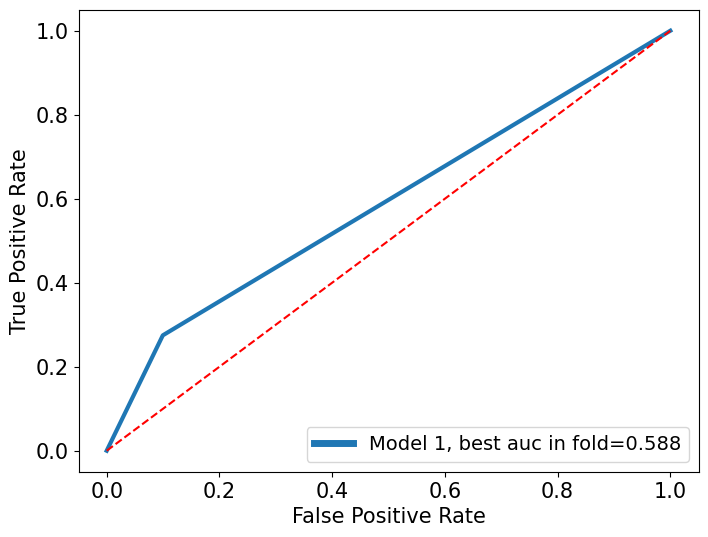

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(best_auc_tabnet[0],best_auc_tabnet[1],label="{}, best auc in fold={:.3f}".format("Model 1",best_auc_tabnet[2]),linewidth=3)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
leg = plt.legend(loc="lower right", prop={'size': 14})
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
plt.show()

In [ ]:
res_all_tabnet[0]

[0.8121546961325967,
 0.7955801104972375,
 0.8265682656826568,
 0.8376383763837638,
 0.8247232472324724]

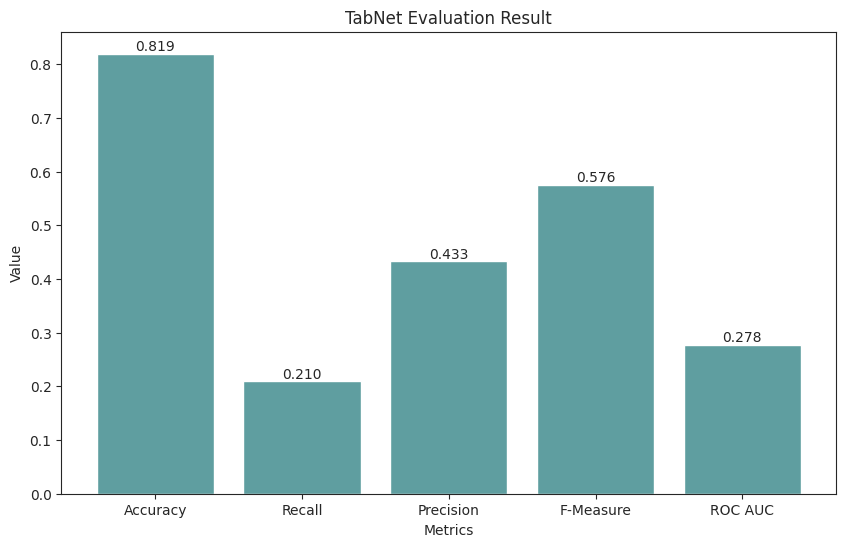

In [ ]:
avg_accuracy = np.mean(res_all_tabnet[0])
avg_recall = np.mean(res_all_tabnet[1])
avg_precision = np.mean(res_all_tabnet[2])
avg_roc_auc = np.mean(res_all_tabnet[3])
avg_f_measure = np.mean(res_all_tabnet[4])


metric_names = ['Accuracy', 'Recall', 'Precision', 'ROC AUC', 'F-Measure']
average_values_tabnet = [avg_accuracy, avg_recall, avg_precision, avg_roc_auc, avg_f_measure]

plt.figure(figsize=(10, 6))
bars = plt.bar(metric_names, average_values_tabnet, color='cadetblue')
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('TabNet Evaluation Result')

# Annotate the bars with numeric values
for bar, value in zip(bars, average_values_tabnet):
    plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.3f}', ha='center', va='bottom')

plt.show()

In [ ]:
model_tabnet = TabNetClassifier(optimizer_fn=torch.optim.Adam, scheduler_params={"step_size":10, "gamma":0.9}, scheduler_fn=torch.optim.lr_scheduler.StepLR, verbose=1, seed=42)
model_tabnet.fit(x_train_tabnet, y_train_tabnet,
                 eval_set=[(x_train_tabnet, y_train_tabnet), (x_test_tabnet, y_test_tabnet)],
                 eval_name=['train', 'val'],
                 eval_metric=['auc','accuracy'],
                 max_epochs=500, patience=0,
                 batch_size=32, virtual_batch_size=256,
                 num_workers=0,
                 weights=0,
                 drop_last=False
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.72587 | train_auc: 0.50375 | train_accuracy: 0.51778 | val_auc: 0.57989 | val_accuracy: 0.51565 |  0:00:04s
epoch 1  | loss: 0.69188 | train_auc: 0.54793 | train_accuracy: 0.55064 | val_auc: 0.53855 | val_accuracy: 0.61326 |  0:00:08s
epoch 2  | loss: 0.6913  | train_auc: 0.49839 | train_accuracy: 0.50801 | val_auc: 0.54335 | val_accuracy: 0.26335 |  0:00:13s
epoch 3  | loss: 0.68731 | train_auc: 0.54932 | train_accuracy: 0.54575 | val_auc: 0.53879 | val_accuracy: 0.29098 |  0:00:18s
epoch 4  | loss: 0.68567 | train_auc: 0.58966 | train_accuracy: 0.56313 | val_auc: 0.40308 | val_accuracy: 0.5046  |  0:00:22s
epoch 5  | loss: 0.67898 | train_auc: 0.62634 | train_accuracy: 0.58621 | val_auc: 0.56453 | val_accuracy: 0.41068 |  0:00:27s
epoch 6  | loss: 0.66291 | train_auc: 0.65    | train_accuracy: 0.6215  | val_auc: 0.59638 | val_accuracy: 0.55249 |  0:00:32s
epoch 7  | loss: 0.65613 | train_auc: 0.68225 | train_accuracy: 0.63807 | val_auc: 0.61827 | val_accuracy: 0.59

In [ ]:
# dgn SMOTE
pred = model_tabnet.predict(x_test_tabnet)
print(classification_report(y_test_tabnet, pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       448
           1       0.46      0.41      0.43        95

    accuracy                           0.81       543
   macro avg       0.67      0.65      0.66       543
weighted avg       0.80      0.81      0.81       543



In [ ]:
# dgn ADASYN
pred = model_tabnet.predict(x_test_tabnet)
print(classification_report(y_test_tabnet, pred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       448
           1       0.41      0.35      0.38        95

    accuracy                           0.80       543
   macro avg       0.64      0.62      0.63       543
weighted avg       0.79      0.80      0.79       543



In [ ]:
pred

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,

In [ ]:
x_train_tabnet.shape

(2169, 4182)

# Evaluasi

In [ ]:
# Load pickle model history
with open('history_seresnext50_1to5_noFS_SMOTE_100ep.pkl', "rb") as file_pi:
    history_seresnext = pickle.load(file_pi)

In [ ]:
history_seresnext

{'loss': [0.6315439343452454,
  0.5801544189453125,
  0.5329163670539856,
  0.531018078327179,
  0.510492205619812,
  0.5031909942626953,
  0.4929336607456207,
  0.49204006791114807,
  0.4749135673046112,
  0.4781090319156647,
  0.4697602391242981,
  0.4547477066516876,
  0.45214954018592834,
  0.4551304578781128,
  0.4363382160663605,
  0.435966432094574,
  0.43446922302246094,
  0.4266837537288666,
  0.42753541469573975,
  0.4090094566345215,
  0.39683032035827637,
  0.40660151839256287,
  0.40425214171409607,
  0.4085594415664673,
  0.38197246193885803,
  0.36754870414733887,
  0.379525750875473,
  0.38932564854621887,
  0.36666300892829895,
  0.3611947000026703,
  0.3660261332988739,
  0.3685306906700134,
  0.36153286695480347,
  0.3542732000350952,
  0.3410395383834839,
  0.36014890670776367,
  0.3362765610218048,
  0.3465888202190399,
  0.32151108980178833,
  0.32889458537101746,
  0.3371058702468872,
  0.3171881437301636,
  0.3079147934913635,
  0.32103076577186584,
  0.30184698

In [ ]:
saved_resnet_model = load_model('seresnext50_1to5_noFS_noSMOTE_100ep.h5')
saved_resnet_model.evaluate(x_test, y_test_ohc2)

17/17 [==============================] - 14s 58ms/step - loss: 0.8740 - accuracy: 0.7514


[0.8739930987358093, 0.7513812184333801]

In [ ]:
pred_seresnext = saved_resnet_model.predict(x_test)
pred_seresnext = np.where(pred_seresnext > 0.5, 1., 0.)
print(classification_report(y_test_ohc2, pred_seresnext))

17/17 [==============================] - 5s 37ms/step
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       448
           1       0.26      0.22      0.24        95

   micro avg       0.75      0.75      0.75       543
   macro avg       0.55      0.54      0.54       543
weighted avg       0.74      0.75      0.74       543
 samples avg       0.75      0.75      0.75       543



In [ ]:
y_test_ohc2

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [ ]:
x_test

,0_pep,1_pep,2_pep,3_pep,4_pep,5_pep,6_pep,7_pep,8_pep,9_pep,...,Y1432_prot,Y1433_prot,Y1434_prot,Y1435_prot,Y1436_prot,Y1437_prot,Y1438_prot,Y1439_prot,Y1440_prot,Y1441_prot
506,0.940182,0.000000,0.733832,0.879720,0.904017,0.072531,0.631520,0.597870,0.306240,0.000000,...,1,1,6,1,1,5,4,4,5,6
1533,0.992450,0.713889,0.759646,0.944156,0.983366,0.747714,0.847615,0.767944,0.621440,0.891754,...,0,0,0,0,0,0,0,0,0,0
1902,0.962337,0.154429,0.666999,0.934413,0.946739,0.278348,0.769308,0.718385,0.469034,0.574987,...,0,0,0,0,0,0,0,0,0,0
2132,0.841271,0.770239,0.409698,0.311124,0.499806,0.800893,0.925124,0.932662,0.922623,0.973329,...,0,0,0,0,0,0,0,0,0,0
2675,0.901855,0.940350,0.959248,0.952197,0.891015,0.988853,0.972002,0.842387,0.945961,0.933323,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1929,0.997922,0.862380,0.878457,0.975669,1.000000,0.883076,0.893457,0.834289,0.823963,0.845748,...,4,4,4,5,1,2,5,1,4,6
1461,0.901855,0.940350,0.959248,0.952197,0.891015,0.988853,0.972002,0.842387,0.945961,0.933323,...,0,0,0,0,0,0,0,0,0,0
2375,0.894098,0.564225,0.682122,0.703562,0.848136,0.444013,0.691159,0.000000,0.690629,0.770078,...,0,0,0,0,0,0,0,0,0,0
999,0.929745,0.083958,0.709934,0.835121,0.890077,0.125211,0.668550,0.475089,0.169609,0.138786,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pred_seresnext

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

### Hasil

In [ ]:
def printhasil(array_hasil):
  print('===============================')
  print('Average Result of {} CV'.format(5))
  print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(array_hasil[0]), np.std(array_hasil[0])))
  print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(array_hasil[1]), np.std(array_hasil[1])))
  print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(array_hasil[2]), np.std(array_hasil[2])))
  print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(array_hasil[3]), np.std(array_hasil[3])))
  print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(array_hasil[4]), np.std(array_hasil[4])))

In [ ]:
#RF
print("Hasil RF")
printhasil(res_all_rf)

Hasil RF
Average Result of 5 CV
Accuracy    : 0.85324±0.006
Recall      : 0.61424±0.051
Precision   : 0.33187±0.020
ROC-AUC     : 0.64470±0.009
F1 Score    : 0.42970±0.018


In [ ]:
#XGBoost
print("Hasil XGBoost")
printhasil(res_all_xgb)

Hasil XGBoost
Average Result of 5 CV
Accuracy    : 0.85176±0.008
Recall      : 0.59538±0.052
Precision   : 0.35834±0.027
ROC-AUC     : 0.65439±0.012
F1 Score    : 0.44601±0.024


In [ ]:
#CNN
print("Hasil CNN")
printhasil(res_all_cnn)

Hasil CNN
Average Result of 5 CV
Accuracy    : 0.75404±0.026
Recall      : 0.19039±0.057
Precision   : 0.13719±0.028
ROC-AUC     : 0.50731±0.024
F1 Score    : 0.15818±0.037


In [ ]:
#SAE-DNN
print("Hasil SAE-DNN")
printhasil(res_all_sae)

Hasil SAE-DNN
Average Result of 5 CV
Accuracy    : 0.81379±0.005
Recall      : 0.33607±0.060
Precision   : 0.42307±0.027
ROC-AUC     : 0.62268±0.027
F1 Score    : 0.37332±0.046


In [ ]:
#TabNet
print("Hasil TabNet")
printhasil(res_all_tabnet)

Hasil TabNet
Average Result of 5 CV
Accuracy    : 0.77175±0.012
Recall      : 0.48220±0.069
Precision   : 0.36119±0.021
ROC-AUC     : 0.65592±0.027
F1 Score    : 0.41148±0.035


## Plotting

In [ ]:
best_auc_tabnet

[array([0.        , 0.19247788, 1.        ]),
 array([0.        , 0.59340659, 1.        ]),
 0.7004643586501994]

### AUC curve

<ipython-input-137-11ff816bfbfd>:15: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in leg.legendHandles:


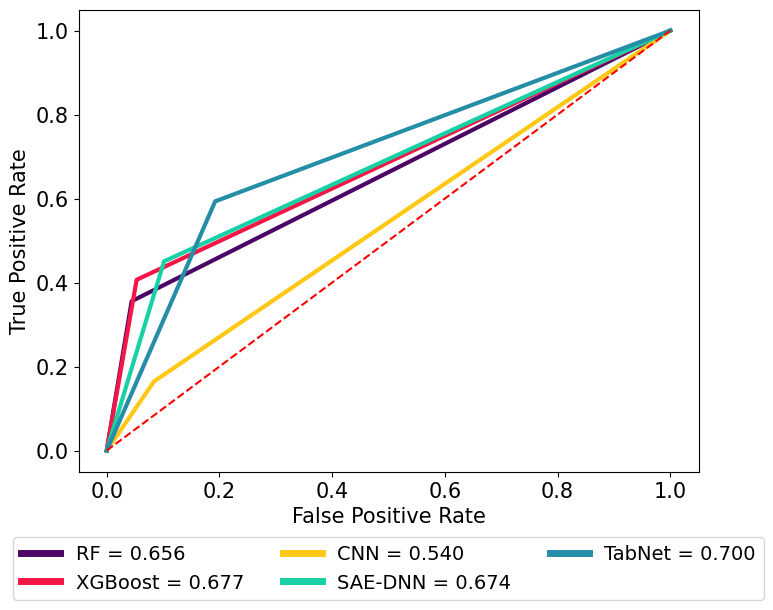

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(best_auc_rf[0],best_auc_rf[1],label="{} = {:.3f}".format("RF",best_auc_rf[2]),linewidth=3, color='#4B0665')
plt.plot(best_auc_xgb[0],best_auc_xgb[1],label="{} = {:.3f}".format("XGBoost",best_auc_xgb[2]),linewidth=3, color='#F41646')
plt.plot(best_auc_cnn[0],best_auc_cnn[1],label="{} = {:.3f}".format("CNN",best_auc_cnn[2]),linewidth=3, color='#FFC814')
plt.plot(best_auc_sae[0],best_auc_sae[1],label="{} = {:.3f}".format("SAE-DNN",best_auc_sae[2]),linewidth=3, color='#17D0A5')
plt.plot(best_auc_tabnet[0],best_auc_tabnet[1],label="{} = {:.3f}".format("TabNet",best_auc_tabnet[2]),linewidth=3, color='#258EA6')

plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

leg = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=3, prop={'size': 14})
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
plt.show()

### Histogram

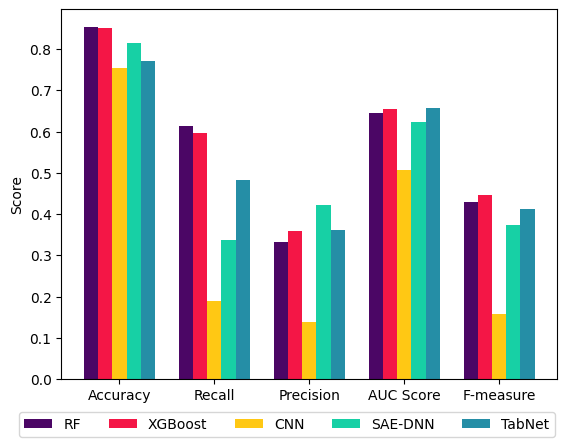

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace this with your actual metric results)
model_names = ['RF', 'XGBoost', 'CNN', 'SAE-DNN', 'TabNet']
accuracy_scores = [np.mean(res_all_rf[0]), np.mean(res_all_xgb[0]), np.mean(res_all_cnn[0]), np.mean(res_all_sae[0]), np.mean(res_all_tabnet[0])]
recall_scores = [np.mean(res_all_rf[1]), np.mean(res_all_xgb[1]), np.mean(res_all_cnn[1]), np.mean(res_all_sae[1]), np.mean(res_all_tabnet[1])]
precision_scores = [np.mean(res_all_rf[2]), np.mean(res_all_xgb[2]), np.mean(res_all_cnn[2]), np.mean(res_all_sae[2]), np.mean(res_all_tabnet[2])]
auc_scores = [np.mean(res_all_rf[3]), np.mean(res_all_xgb[3]), np.mean(res_all_cnn[3]), np.mean(res_all_sae[3]), np.mean(res_all_tabnet[3])]
f_measure_scores = [np.mean(res_all_rf[4]), np.mean(res_all_xgb[4]), np.mean(res_all_cnn[4]), np.mean(res_all_sae[4]), np.mean(res_all_tabnet[4])]

# Combine the metric results
metrics = {
    'Accuracy': accuracy_scores,
    'Recall': recall_scores,
    'Precision': precision_scores,
    'AUC Score': auc_scores,
    'F-measure': f_measure_scores
}

# Define custom colors for each model
custom_colors = ['#4B0665', '#F41646', '#FFC814', '#17D0A5', '#258EA6']

# Create a bar chart with grouped bars for each model
bar_width = 0.15
index = np.arange(len(metrics))

for i, (model_name, color) in enumerate(zip(model_names, custom_colors)):
    plt.bar(index + i * bar_width, [metrics[metric][i] for metric in metrics], bar_width, label=model_name, color=color)

plt.ylabel('Score')
plt.xticks(index + bar_width * (len(model_names) - 1) / 2, metrics.keys())
plt.legend(loc='upper center', bbox_to_anchor=(0.455, -0.07), ncol=len(model_names))
plt.show()



### Confusion Matrix

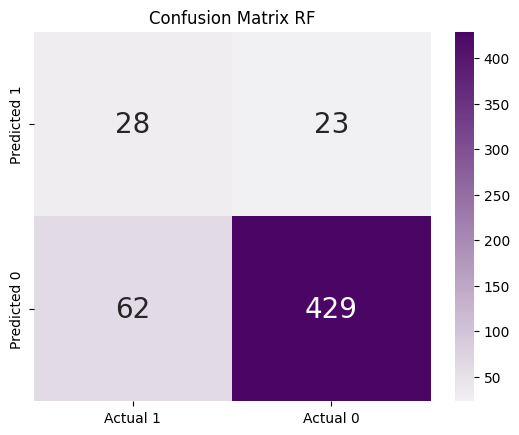

In [ ]:
# Custom color (replace 'your_hex_code' with the desired hex code)
custom_color = sns.color_palette("light:#4B0665", as_cmap=True)

# Plotting the confusion matrix with custom color
def plot_confusion_matrix(conf_matrix):
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_color, xticklabels=['Actual 1', 'Actual 0'], yticklabels=['Predicted 1', 'Predicted 0'],
                annot_kws={'size':20})
    plt.title('Confusion Matrix RF')
    plt.show()

# Call the function with your confusion matrix
plot_confusion_matrix(confusion_matrix_rf)

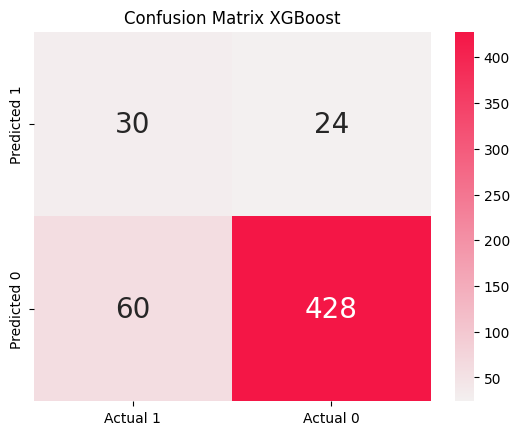

In [ ]:
# Custom color (replace 'your_hex_code' with the desired hex code)
custom_color = sns.color_palette("light:#F41646", as_cmap=True)

# Plotting the confusion matrix with custom color
def plot_confusion_matrix(conf_matrix):
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_color, xticklabels=['Actual 1', 'Actual 0'], yticklabels=['Predicted 1', 'Predicted 0'],
                annot_kws={'size':20})
    plt.title('Confusion Matrix XGBoost')
    plt.show()

# Call the function with your confusion matrix
plot_confusion_matrix(confusion_matrix_xgb)

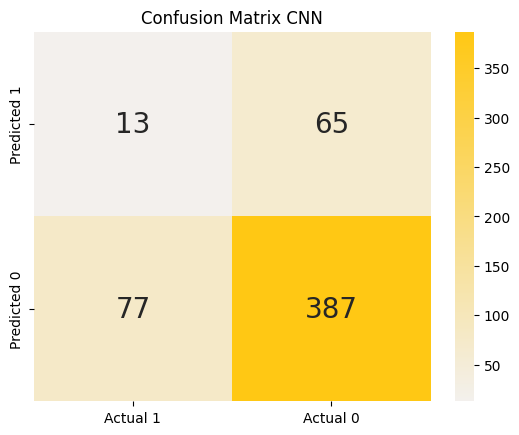

In [ ]:
# Custom color (replace 'your_hex_code' with the desired hex code)
custom_color = sns.color_palette("light:#FFC814", as_cmap=True)

# Plotting the confusion matrix with custom color
def plot_confusion_matrix(conf_matrix):
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_color, xticklabels=['Actual 1', 'Actual 0'], yticklabels=['Predicted 1', 'Predicted 0'],
                annot_kws={'size':20})
    plt.title('Confusion Matrix CNN')
    plt.show()

# Call the function with your confusion matrix
plot_confusion_matrix(confusion_matrix_cnn)

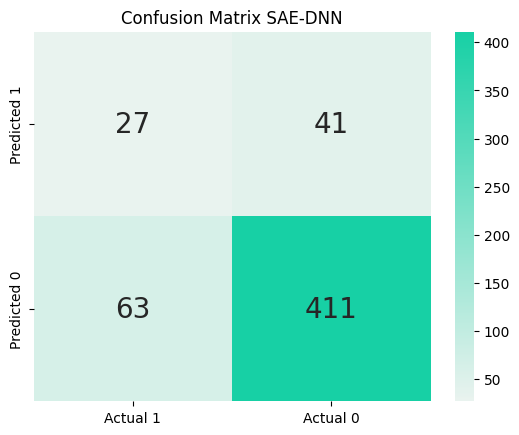

In [ ]:
# Custom color (replace 'your_hex_code' with the desired hex code)
custom_color = sns.color_palette("light:#17D0A5", as_cmap=True)

# Plotting the confusion matrix with custom color
def plot_confusion_matrix(conf_matrix):
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_color, xticklabels=['Actual 1', 'Actual 0'], yticklabels=['Predicted 1', 'Predicted 0'],
                annot_kws={'size':20})
    plt.title('Confusion Matrix SAE-DNN')
    plt.show()

# Call the function with your confusion matrix
plot_confusion_matrix(confusion_matrix_sae)

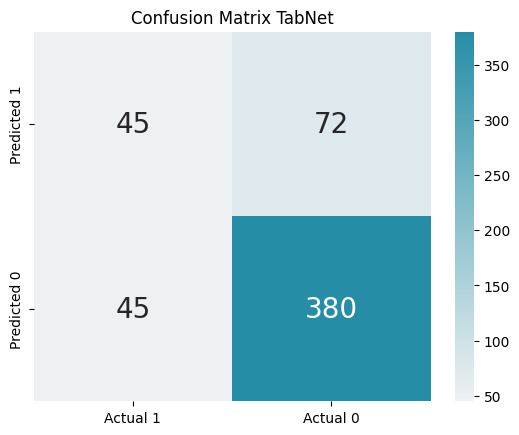

In [ ]:
# Custom color (replace 'your_hex_code' with the desired hex code)
custom_color = sns.color_palette("light:#258EA6", as_cmap=True)

# Plotting the confusion matrix with custom color
def plot_confusion_matrix(conf_matrix):
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_color, xticklabels=['Actual 1', 'Actual 0'], yticklabels=['Predicted 1', 'Predicted 0'],
                annot_kws={'size':20})
    plt.title('Confusion Matrix TabNet')
    plt.show()

# Call the function with your confusion matrix
plot_confusion_matrix(confusion_matrix_tabnet)

## Backup Result

Jangan di running lagi kecuali kalau ingin simpan hasil baru. Ini untuk jaga-jaga runtime disconnected atau hilang.

In [ ]:
confusion_matrix_rf = [[28,23],[62,429]]
confusion_matrix_xgb = [[30,24],[60,428]]
confusion_matrix_cnn = [[13,65],[77,387]]
confusion_matrix_sae = [[27,41],[63,411]]
confusion_matrix_tabnet = [[45,72],[45,380]]

In [ ]:
res_combine = [res_all_rf, res_all_xgb, res_all_cnn, res_all_sae, res_all_tabnet]

In [ ]:
res_all_rf

[[0.848987108655617,
  0.861878453038674,
  0.8560885608856088,
  0.8560885608856088,
  0.8431734317343174],
 [0.5818181818181818, 0.7, 0.625, 0.6153846153846154, 0.5490196078431373],
 [0.3516483516483517,
  0.3076923076923077,
  0.3333333333333333,
  0.35555555555555557,
  0.3111111111111111],
 [0.6503816979480697,
  0.640571817562968,
  0.6467551622418879,
  0.6556538839724682,
  0.6301130776794494],
 [0.4383561643835616,
  0.4274809160305344,
  0.43478260869565216,
  0.4507042253521127,
  0.3971631205673759]]

In [ ]:
res_all_xgb

[[0.856353591160221,
  0.8637200736648251,
  0.8505535055350554,
  0.8431734317343174,
  0.8450184501845018],
 [0.6065573770491803,
  0.6888888888888889,
  0.5849056603773585,
  0.5409836065573771,
  0.5555555555555556],
 [0.4065934065934066,
  0.34065934065934067,
  0.34444444444444444,
  0.36666666666666664,
  0.3333333333333333],
 [0.6767480307303316,
  0.6548429446659535,
  0.6478859390363816,
  0.6523598820058997,
  0.640117994100295],
 [0.4868421052631579,
  0.4558823529411765,
  0.43356643356643354,
  0.4370860927152318,
  0.4166666666666667]]

In [ ]:
res_all_cnn

[[0.7900552486187845,
  0.7624309392265194,
  0.7140221402214022,
  0.7656826568265682,
  0.7380073800738007],
 [0.2830188679245283,
  0.16071428571428573,
  0.11764705882352941,
  0.22388059701492538,
  0.16666666666666666],
 [0.16483516483516483,
  0.0989010989010989,
  0.1111111111111111,
  0.16666666666666666,
  0.14444444444444443],
 [0.540382184187494,
  0.4974593990080716,
  0.4725909537856441,
  0.5258112094395281,
  0.5003195673549655],
 [0.20833333333333331,
  0.12244897959183672,
  0.11428571428571428,
  0.19108280254777069,
  0.15476190476190474]]

In [ ]:
res_all_sae

[[0.8232044198895028,
  0.8158379373848987,
  0.8118081180811808,
  0.8099630996309963,
  0.8081180811808119],
 [0.45054945054945056,
  0.31868131868131866,
  0.2777777777777778,
  0.3333333333333333,
  0.3],
 [0.47126436781609193,
  0.43283582089552236,
  0.4032258064516129,
  0.410958904109589,
  0.39705882352941174],
 [0.6743897695225128,
  0.6173052611105708,
  0.5979596853490659,
  0.6191002949852508,
  0.6046460176991151],
 [0.4606741573033708,
  0.36708860759493667,
  0.32894736842105265,
  0.36809815950920244,
  0.34177215189873417]]

In [ ]:
res_all_tabnet

[[0.7716390423572744,
  0.7808471454880295,
  0.7712177121771218,
  0.7509225092250923,
  0.7841328413284133],
 [0.5934065934065934, 0.4175824175824176, 0.4, 0.5, 0.5],
 [0.3829787234042553,
  0.36538461538461536,
  0.33962264150943394,
  0.3333333333333333,
  0.38461538461538464],
 [0.7004643586501994,
  0.6357823592336866,
  0.6225663716814159,
  0.6504424778761062,
  0.6703539823008848],
 [0.46551724137931033,
  0.38974358974358975,
  0.36734693877551017,
  0.4,
  0.4347826086956522]]

In [ ]:
res_combine

[[[0.848987108655617,
   0.861878453038674,
   0.8560885608856088,
   0.8560885608856088,
   0.8431734317343174],
  [0.5818181818181818, 0.7, 0.625, 0.6153846153846154, 0.5490196078431373],
  [0.3516483516483517,
   0.3076923076923077,
   0.3333333333333333,
   0.35555555555555557,
   0.3111111111111111],
  [0.6503816979480697,
   0.640571817562968,
   0.6467551622418879,
   0.6556538839724682,
   0.6301130776794494],
  [0.4383561643835616,
   0.4274809160305344,
   0.43478260869565216,
   0.4507042253521127,
   0.3971631205673759]],
 [[0.856353591160221,
   0.8637200736648251,
   0.8505535055350554,
   0.8431734317343174,
   0.8450184501845018],
  [0.6065573770491803,
   0.6888888888888889,
   0.5849056603773585,
   0.5409836065573771,
   0.5555555555555556],
  [0.4065934065934066,
   0.34065934065934067,
   0.34444444444444444,
   0.36666666666666664,
   0.3333333333333333],
  [0.6767480307303316,
   0.6548429446659535,
   0.6478859390363816,
   0.6523598820058997,
   0.6401179941002

In [ ]:
auc_combine = [best_auc_rf, best_auc_xgb, best_auc_cnn, best_auc_sae, best_auc_tabnet]

In [ ]:
best_auc_rf

[array([0.        , 0.04424779, 1.        ]),
 array([0.        , 0.35555556, 1.        ]),
 0.6556538839724682]

In [ ]:
best_auc_xgb

[array([0.        , 0.05309735, 1.        ]),
 array([0.        , 0.40659341, 1.        ]),
 0.6767480307303316]

In [ ]:
best_auc_cnn

[array([0.       , 0.0840708, 1.       ]),
 array([0.        , 0.16483516, 1.        ]),
 0.540382184187494]

In [ ]:
best_auc_sae

[array([0.        , 0.10176991, 1.        ]),
 array([0.        , 0.45054945, 1.        ]),
 0.6743897695225128]

In [ ]:
best_auc_tabnet

[array([0.        , 0.19247788, 1.        ]),
 array([0.        , 0.59340659, 1.        ]),
 0.7004643586501994]

In [ ]:
auc_combine

[[array([0.        , 0.04424779, 1.        ]),
  array([0.        , 0.35555556, 1.        ]),
  0.6556538839724682],
 [array([0.        , 0.05309735, 1.        ]),
  array([0.        , 0.40659341, 1.        ]),
  0.6767480307303316],
 [array([0.       , 0.0840708, 1.       ]),
  array([0.        , 0.16483516, 1.        ]),
  0.540382184187494],
 [array([0.        , 0.10176991, 1.        ]),
  array([0.        , 0.45054945, 1.        ]),
  0.6743897695225128],
 [array([0.        , 0.19247788, 1.        ]),
  array([0.        , 0.59340659, 1.        ]),
  0.7004643586501994]]